# Main model

## old code

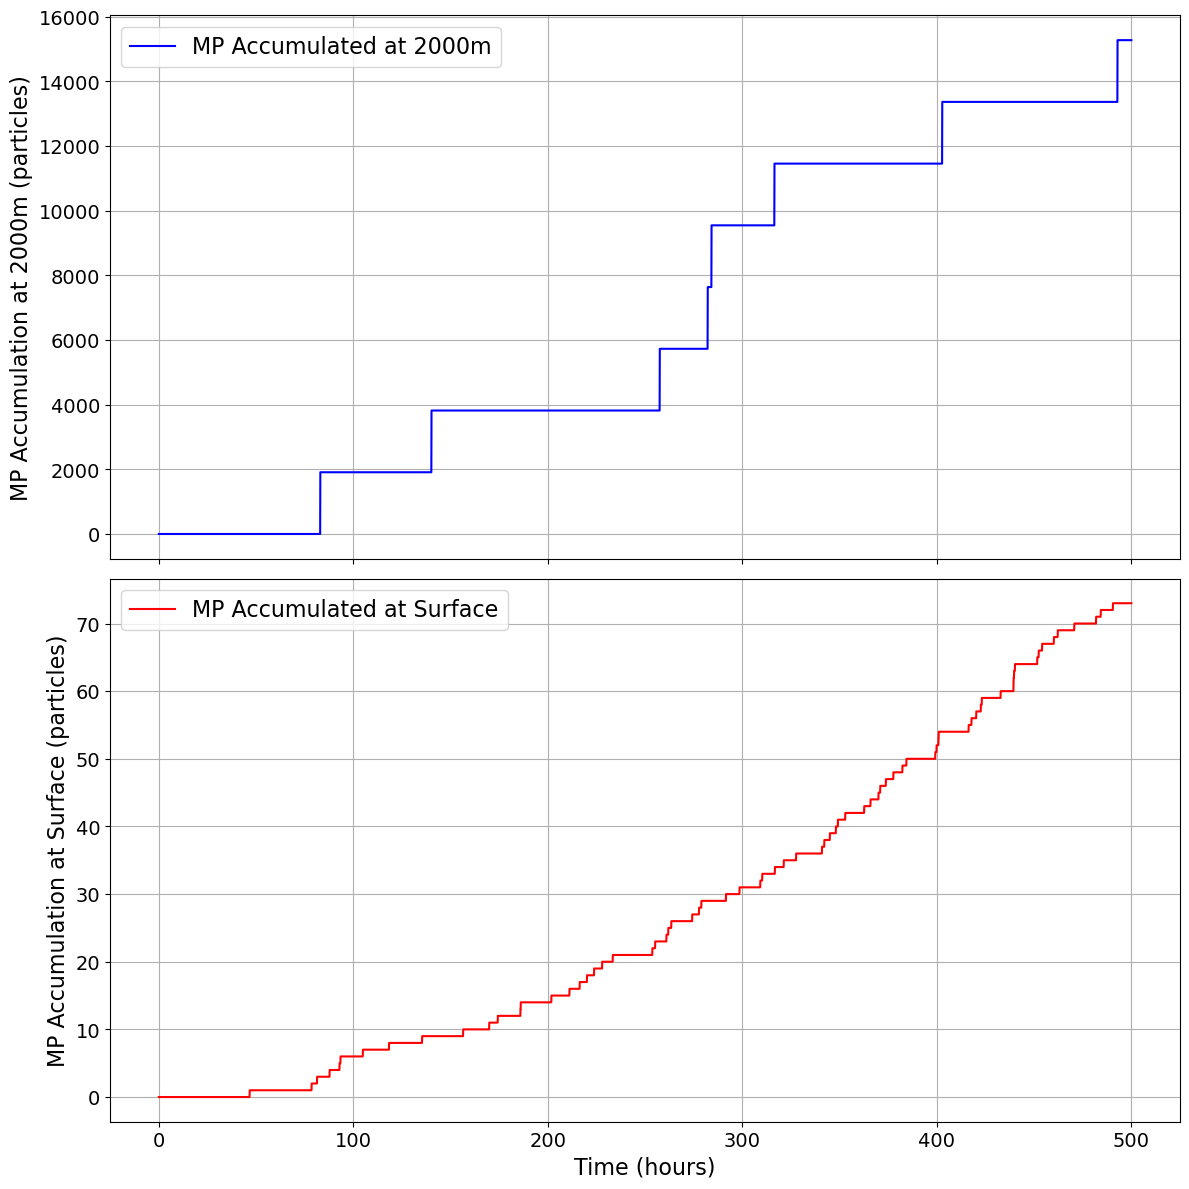

Avg sinking velocity: 466.5155472737943 m/day, Avg rising velocity: 0.747469777086894 m/hour
[41.5 35.5 29.5 32.5 25.5 19.5 33.5 12.5 34.5 47.5]


In [1]:
#%% more efficient main code
import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_rising_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens,
    assign_mp_size,
    assign_krill_length
)
import netCDF4 as nc
import pandas as pd

# Parameters
krill_length_mm = assign_krill_length(10)  # mm
depth_limit = 2000  # m
time = np.linspace(0, 500, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mass_loss_threshold = 0.4  # Stop sinking when 40% of mass is lost
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Get the density data
rho_data_path = 'C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

for krill_length in krill_length_mm:
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize arrays to store microplastic accumulation at max depth
    mp_accumulation_at_2000m = np.zeros_like(time)
    pellets_reaching_2000m = 0



    # Track when MP reaches 2000m
    def find_nearest_index(array, value):
        return (np.abs(array - value)).argmin()

    # Precompute random values for L_init, D, rho_s, and mp_size
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
    rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
    mp_size = assign_mp_size(size=num_pellets)

    # Precompute break depths and break chances
    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.5

    # Store rising microplastics' data
    rising_mp = []  # List to track (depth, release_time, rising velocity)

    # Simulate sinking for each fecal pellet without breakage
    for i, release_time in enumerate(fp_release_times):
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        time_at_2000m = None
        broke = False
        mp_released = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                time_at_2000m = release_time + t
                pellets_reaching_2000m += 1
                break
            
            # Calculate the density at the current depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            # Update length based on depth
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)

            # Apply breakage if within top 300m
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  # Only break once per pellet
                L = (L_init[i] - delta_L) / 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    
                    # Calculate rising velocity
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24  # Convert to m/hour
                    rising_mp.append((current_depth, release_time + t, wr))  # Store data# Store depth of MP release
                else:
                    mp_released = False
            else:
                L = L_init[i] - delta_L

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            ws_per_hour = ws / 24
            current_depth += ws_per_hour * dt

        if reached_2000m and time_at_2000m is not None:
            contains_mp = (not mp_released and
                        np.any(np.isclose(release_time, mp_fp_release_times, atol=gut_passage_time / 2)) and mp_size[i] < D[i])
            if contains_mp:
                index = find_nearest_index(time, time_at_2000m)
                mp_accumulation_at_2000m[index] += mp_conc
                
                
    # Simulate rising microplastics
    mp_rising_accumulation = np.zeros_like(time)
    # Set of counted indices to avoid multiple counts
    counted_indices = set()

    for depth, release_time, wr in rising_mp:
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        # Track if the microplastic has already been counted
        counted = False

        for t in time_since_release:
            # Stop tracking once the microplastic reaches the surface (depth <= 100)
            if depth <= 100 and not counted:
                # Find the nearest index when it reaches the surface
                index = find_nearest_index(time, release_time + t)
                # Only count once at the surface
                if index not in counted_indices:
                    mp_rising_accumulation[index] += 1
                    counted_indices.add(index)
                    counted = True  # Mark as counted when it reaches the surface
                break  # Stop further tracking for this microplastic
            
            depth -= wr * dt  # Move upwards


mp_rising_accumulation = np.cumsum(mp_rising_accumulation)


mp_accumulation_at_2000m = np.cumsum(mp_accumulation_at_2000m)


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plot accumulation at 2000m
axes[0].plot(time, mp_accumulation_at_2000m, color='blue', label="MP Accumulated at 2000m")
axes[0].set_ylabel("MP Accumulation at 2000m (particles)", fontsize=16)  # Larger label
#axes[0].set_title("Microplastic Accumulation at 2000m", fontsize=20)  # Larger title
axes[0].grid()
axes[0].legend(fontsize=16)

# Plot accumulation at the surface
axes[1].plot(time, mp_rising_accumulation, color='red', label="MP Accumulated at Surface")
axes[1].set_xlabel("Time (hours)", fontsize=16)  # Larger label
axes[1].set_ylabel("MP Accumulation at Surface (particles)", fontsize=16)  # Larger label
#axes[1].set_title("Microplastic Accumulation at the Surface", fontsize=20)  # Larger title
axes[1].grid()
axes[1].legend(fontsize=16)

# Increase font size of ticks 
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)  # Larger tick labels
    ax.tick_params(axis='both', which='minor', labelsize=12)  # Optional: minor ticks

# Display the plots
plt.tight_layout()
plt.show()


print(f"Avg sinking velocity: {np.mean(ws)} m/day, Avg rising velocity: {np.mean([w[2] for w in rising_mp])} m/hour")
# print(np.mean(mp_release_depths))

print(krill_length_mm)

## More efficient code 

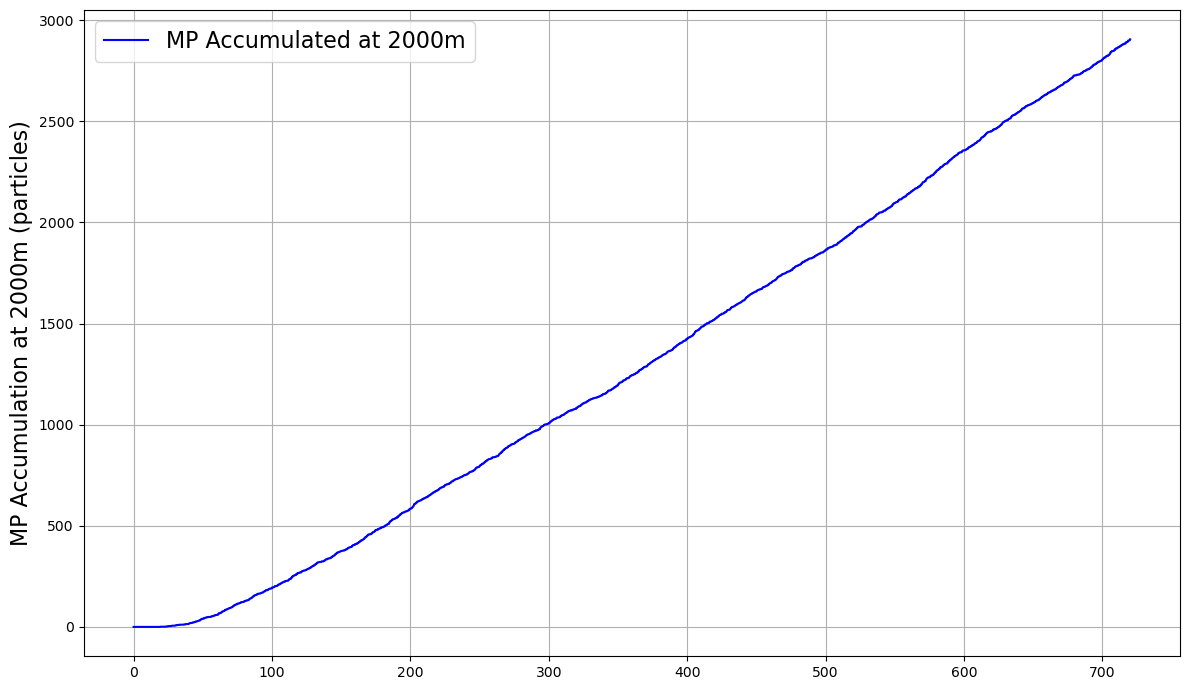

Average gradient of MP Accumulated at 2000m between 300 and 500 hours: 4.285771516024527


In [ ]:
##Actually more efficient main code!

import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length
)

# Simulation Parameters
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# Get krill lengths
krill_lengths = assign_krill_length(20)

#calculate proportion of krill_length > 10

num_krill_above_10 = np.count_nonzero(krill_lengths > 10)
num_krill_below_10 = np.count_nonzero(krill_lengths <= 10)
krill_length_proportion = num_krill_above_10 / (num_krill_above_10 + num_krill_below_10)
krill_length_proportion_bel = num_krill_below_10 / (num_krill_above_10 + num_krill_below_10)

def simulate_krill(krill_length, krill_length_proportion, krill_length_proportion_bel):
    """Simulates one krill's impact on microplastic flux."""
    
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize accumulation arrays
    mp_accumulation_at_2000m = np.zeros_like(time)
    pellets_reaching_2000m = 0
    rising_mp = []

    # Precompute random variables
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
    mp_size = assign_mp_size(size=num_pellets)

    # making the widths of the pellets slighly dependent on the krill length
    if krill_length > 18e-6:
        D = generate_random(183, 178, 200, 600, size= int(num_pellets * krill_length_proportion)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 400, size= int(num_pellets * krill_length_proportion_bel)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    # Simulate sinking for each fecal pellet
    for i, release_time in enumerate(fp_release_times):
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                pellets_reaching_2000m += 1
                break
            
            # Update density based on depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L


            # Breakage handling
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  
                L /= 2 # Break length in half
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))
                else:
                    mp_released = False
            
            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt  # Convert to hourly movement

        if reached_2000m and not mp_released and np.any(np.isclose(release_time, mp_fp_release_times, atol=gut_passage_time / 2)) and mp_size[i] < D[i]:
            # If the pellet reaches 2000m and contains microplastics, accumulate
            index = (np.abs(time - (release_time + t))).argmin()
            mp_accumulation_at_2000m[index] += 1
    
    return mp_accumulation_at_2000m, rising_mp


# ** Run Parallel Simulations **
results = Parallel(n_jobs=-1)(delayed(simulate_krill)(length, krill_length_proportion, krill_length_proportion_bel) for length in krill_lengths)

# Aggregate results
mp_accumulation_at_2000m = np.zeros_like(time)
rising_mp = []

for acc, rising in results:
    mp_accumulation_at_2000m += acc
    rising_mp.extend(rising)

# Simulate rising microplastics
mp_rising_accumulation = np.zeros_like(time)
counted_indices = set()

for depth, release_time, wr in rising_mp:
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time

    for t in time_since_release:
        if depth <= 100:
            index = (np.abs(time - (release_time + t))).argmin()
            if index not in counted_indices:
                mp_rising_accumulation[index] += 1
                counted_indices.add(index)
            break
        depth -= wr * (time[1] - time[0])

mp_rising_accumulation = np.cumsum(mp_rising_accumulation)
mp_accumulation_at_2000m = np.cumsum(mp_accumulation_at_2000m)

# Plot Results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))

axes.plot(time, mp_accumulation_at_2000m, color='blue', label="MP Accumulated at 2000m")
axes.set_ylabel("MP Accumulation at 2000m (particles)", fontsize=16)
axes.grid()
axes.legend(fontsize=16)

plt.tight_layout()
plt.show()

# Approximate the gradient between 300 and 500 hours
time_range = (time >= 300) & (time <= 500)
time_selected = time[time_range]

# Gradient for MP Accumulated at 2000m
mp_accumulation_gradient_2000m = np.gradient(mp_accumulation_at_2000m[time_range], time_selected)
average_gradient_2000m = np.mean(mp_accumulation_gradient_2000m)

# Gradient for MP Accumulated at Surface
mp_rising_gradient_surface = np.gradient(mp_rising_accumulation[time_range], time_selected)
average_gradient_surface = np.mean(mp_rising_gradient_surface)

print(f"Average gradient of MP Accumulated at 2000m between 300 and 500 hours: {average_gradient_2000m}")
#print(f"Average gradient of MP Accumulated at Surface between 300 and 500 hours: {average_gradient_surface}")

#print(krill_lengths)

In [62]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# --- Simulation Parameters ---
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# --- Prepare Krill Lengths for 1000 x 40 Simulations ---
num_simulations = 10
krill_per_sim = 40
krill_lengths = assign_krill_length(num_simulations * krill_per_sim)
krill_groups = krill_lengths.reshape((num_simulations, krill_per_sim))

# Calculate krill length proportions
num_krill_above_10 = np.count_nonzero(krill_lengths > 10)
num_krill_below_10 = np.count_nonzero(krill_lengths <= 10)
krill_length_proportion = num_krill_above_10 / (num_krill_above_10 + num_krill_below_10)
krill_length_proportion_bel = num_krill_below_10 / (num_krill_above_10 + num_krill_below_10)

# --- Simulation Function ---
def simulate_krill(krill_length, krill_length_proportion, krill_length_proportion_bel):
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    mp_accumulation_at_2000m = np.zeros_like(time)
    rising_mp = []

    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = np.full(num_pellets, 1050)
    mp_size = assign_mp_size(size=num_pellets)

    if krill_length > 18e-6:
        D = generate_random(183, 178, 450, 600, size=int(num_pellets * krill_length_proportion)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 100, size=int(num_pellets * krill_length_proportion_bel)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    is_mp_pellet = np.zeros(num_pellets, dtype=bool)
    tolerance = gut_passage_time / 2

    for i in range(num_pellets):
        time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
        size_condition = (mp_size[i] < D[i])
        is_mp_pellet[i] = time_match and size_condition

    for i, release_time in enumerate(fp_release_times):
        if not is_mp_pellet[i]:
            continue
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                break

            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L

            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True
                L /= 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt

        if reached_2000m and not mp_released:
            arrival_time = release_time + t
            idx = (np.abs(time - arrival_time)).argmin()
            mp_accumulation_at_2000m[idx] += 1

    return mp_accumulation_at_2000m, rising_mp

# --- Run Simulations ---
total_accum_all = np.zeros((num_simulations, len(time)))

for sim_idx, krill_group in enumerate(krill_groups):
    print(f"Running simulation {sim_idx + 1}/{num_simulations}...")

    results = Parallel(n_jobs=-1)(
        delayed(simulate_krill)(length, krill_length_proportion, krill_length_proportion_bel)
        for length in krill_group
    )

    acc_arrays = np.array([acc for acc, _ in results])
    total_accum = np.sum(acc_arrays, axis=0)
    total_accum_all[sim_idx] = np.cumsum(total_accum)


# Compute mean and standard deviation across simulations (axis=0)
mean_acc_all = np.mean(total_accum_all, axis=0)
std_acc_all = np.std(total_accum_all, axis=0)



Running simulation 1/10...
Running simulation 2/10...
Running simulation 3/10...
Running simulation 4/10...
Running simulation 5/10...
Running simulation 6/10...
Running simulation 7/10...
Running simulation 8/10...
Running simulation 9/10...
Running simulation 10/10...


In [63]:
# Combine time, mean, and std into a DataFrame
df_stats = pd.DataFrame({
    'Time (hours)': time,
    'Mean accumulation': mean_acc_all,
    'Standard deviation': std_acc_all
})

# Save to CSV
df_stats.to_csv("krill_mp_accumulation_stats.csv", index=False)
print("Mean and standard deviation saved to 'krill_mp_accumulation_stats.csv'")


Mean and standard deviation saved to 'krill_mp_accumulation_stats.csv'


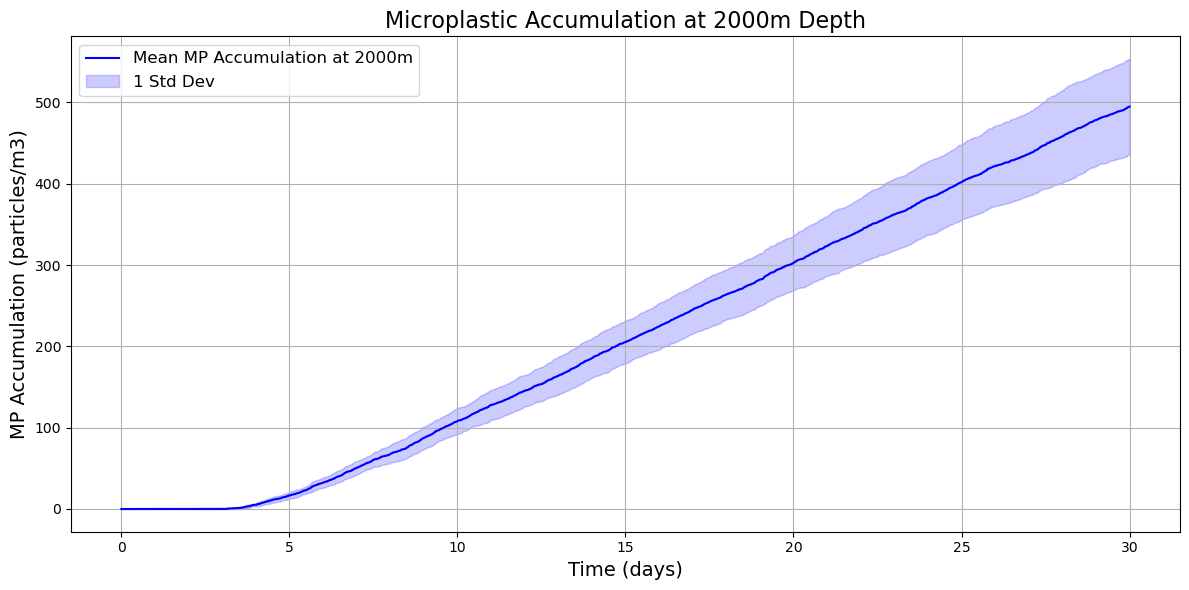

Average gradient of MP Accumulation at 2000m between 300 and 600 hours: 19.88119299087849 particles/m3/day
Average gradient of MP Accumulation at 2000m between 300 and 600 hours: 0.8283830412866037
Time until first zero accumulation: 2.907290729072907 days
Average time until first zero accumulation across all simulations: 0.0 days


In [90]:
#plotting the results 
plt.figure(figsize=(12, 6))
#turn time into dyas
time_days = time / 24
plt.plot(time_days, mean_acc_all, label='Mean MP Accumulation at 2000m', color='blue')
plt.fill_between(time_days, mean_acc_all - std_acc_all, mean_acc_all + std_acc_all, color='blue', alpha=0.2, label='1 Std Dev')
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('MP Accumulation (particles/m3)', fontsize=14)
plt.title('Microplastic Accumulation at 2000m Depth', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

#gradient of the plots 
time_range = (time >= 300) & (time <= 600)
time_selected = time[time_range]
mp_accumulation_gradient_all = np.gradient(mean_acc_all[time_range], time_selected)
average_gradient_all = np.mean(mp_accumulation_gradient_all)
average_gradient_day = average_gradient_all * 24  # Convert to days
print(f"Average gradient of MP Accumulation at 2000m between 300 and 600 hours: {average_gradient_day} particles/m3/day")
print(f"Average gradient of MP Accumulation at 2000m between 300 and 600 hours: {average_gradient_all}")

#how long for the accumulation to not be 0 
zero_indices = np.where(mean_acc_all == 0)[0]
if zero_indices.size > 0:
    first_zero_index = zero_indices[-1]
    time_to_first_zero = time[first_zero_index] / 24  # Convert to days
    print(f"Time until first zero accumulation: {time_to_first_zero} days")
else:
    print("No zero accumulation found in the data.")
# Calculate the average time until first zero accumulation across all simulations
average_time_to_last_zero = np.mean([np.where(acc == 0)[0][0] for acc in total_accum_all if np.any(acc == 0)]) / 24  # Convert to days
print(f"Average time until first zero accumulation across all simulations: {average_time_to_last_zero} days")




In [51]:
##plotting mean and std for each krill

import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# Simulation Parameters
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# Get krill lengths
krill_lengths = assign_krill_length(1000)

# Calculate proportion of krill_length > 10
num_krill_above_10 = np.count_nonzero(krill_lengths > 10)
num_krill_below_10 = np.count_nonzero(krill_lengths <= 10)
krill_length_proportion = num_krill_above_10 / (num_krill_above_10 + num_krill_below_10)
krill_length_proportion_bel = num_krill_below_10 / (num_krill_above_10 + num_krill_below_10)

def simulate_krill(krill_length, krill_length_proportion, krill_length_proportion_bel):
    """Simulates one krill's impact on microplastic flux, returning:
       (mp_accumulation_at_2000m, rising_mp_list)."""
    
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize accumulation array
    mp_accumulation_at_2000m = np.zeros_like(time)
    rising_mp = []  # we will process rising later

    # Precompute random variables
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = np.full(num_pellets, 1050)

    mp_size = assign_mp_size(size=num_pellets)

    # Make pellet width slightly dependent on krill length
    if krill_length > 18e-6:
        D = generate_random(183, 178, 450, 600, size=int(num_pellets * krill_length_proportion)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 100, size=int(num_pellets * krill_length_proportion_bel)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    # Identify MP-containing pellets
    tolerance = gut_passage_time / 2
    is_mp_pellet = np.zeros(num_pellets, dtype=bool)


    for i in range(num_pellets):
        # Check if release time matches MP pellet release times
        time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
        # Check if MP size is smaller than pellet diameter
        size_condition = (mp_size[i] < D[i])
        is_mp_pellet[i] = time_match and size_condition

    # Calculate the proportion of MP-containing fecal pellets
    mp_count = np.sum(is_mp_pellet)
    total_pellets = len(is_mp_pellet)
    mp_proportion = mp_count / total_pellets
    print(f"Proportion of MP-containing fecal pellets for krill with length {krill_length} m: {mp_proportion:.4f}")

    # Simulate sinking for each fecal pellet only if it contains microplastics 
    for i, release_time in enumerate(fp_release_times):
        if not is_mp_pellet[i]:
            continue
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                # Pellet has reached 2000m
                reached_2000m = True
                break

            # Update density based on current depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            # Length decrease
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L

            # Breakage
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  
                L /= 2  # Break length in half
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    # Store info so we can process the rising pellet after the loop
                    rising_mp.append((current_depth, release_time + t, wr))
                else:
                    mp_released = False
            
            # Update sinking speed and depth
            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt  # Convert to hourly movement

        # If the pellet reached 2000m without releasing the MP
        if reached_2000m and not mp_released:
            arrival_time = release_time + t
            idx = (np.abs(time - arrival_time)).argmin()
            mp_accumulation_at_2000m[idx] += 1
    
    return mp_accumulation_at_2000m, rising_mp

acc_arrays = np.zeros((len(krill_lengths), len(time)))  # Make sure this is large enough


# Run simulations in parallel
results = Parallel(n_jobs=-1)(
    delayed(simulate_krill)(length, krill_length_proportion, krill_length_proportion_bel)
    for length in krill_lengths
)


# Save results properly, assuming `simulate_krill` returns data for each krill
for i, (acc, rising) in enumerate(results):
    if i < len(acc_arrays):
        acc_arrays[i] = acc
        

# Convert to NumPy arrays
acc_arrays = np.array(acc_arrays)      # shape: (num_krill, len(time))

# Take the cumulative sum over time for each krill, so each row is monotonic
acc_cumsum = np.cumsum(acc_arrays, axis=1)

# Compute mean and std across krill at each time step
mean_acc = np.mean(acc_cumsum, axis=0)
std_acc = np.std(acc_cumsum, axis=0)




In [49]:
print(len(krill_lengths))

1000


In [52]:
#save the mean and std to a csv file
mean_std_df = pd.DataFrame({
    'Time': time,
    'Mean_Accumulation': mean_acc,
    'Std_Accumulation': std_acc
})
mean_std_df.to_csv('mean_std_accumulation_2000m.csv', index=False)
print(mean_std_df.head())

       Time  Mean_Accumulation  Std_Accumulation
0  0.000000                0.0               0.0
1  0.072007                0.0               0.0
2  0.144014                0.0               0.0
3  0.216022                0.0               0.0
4  0.288029                0.0               0.0


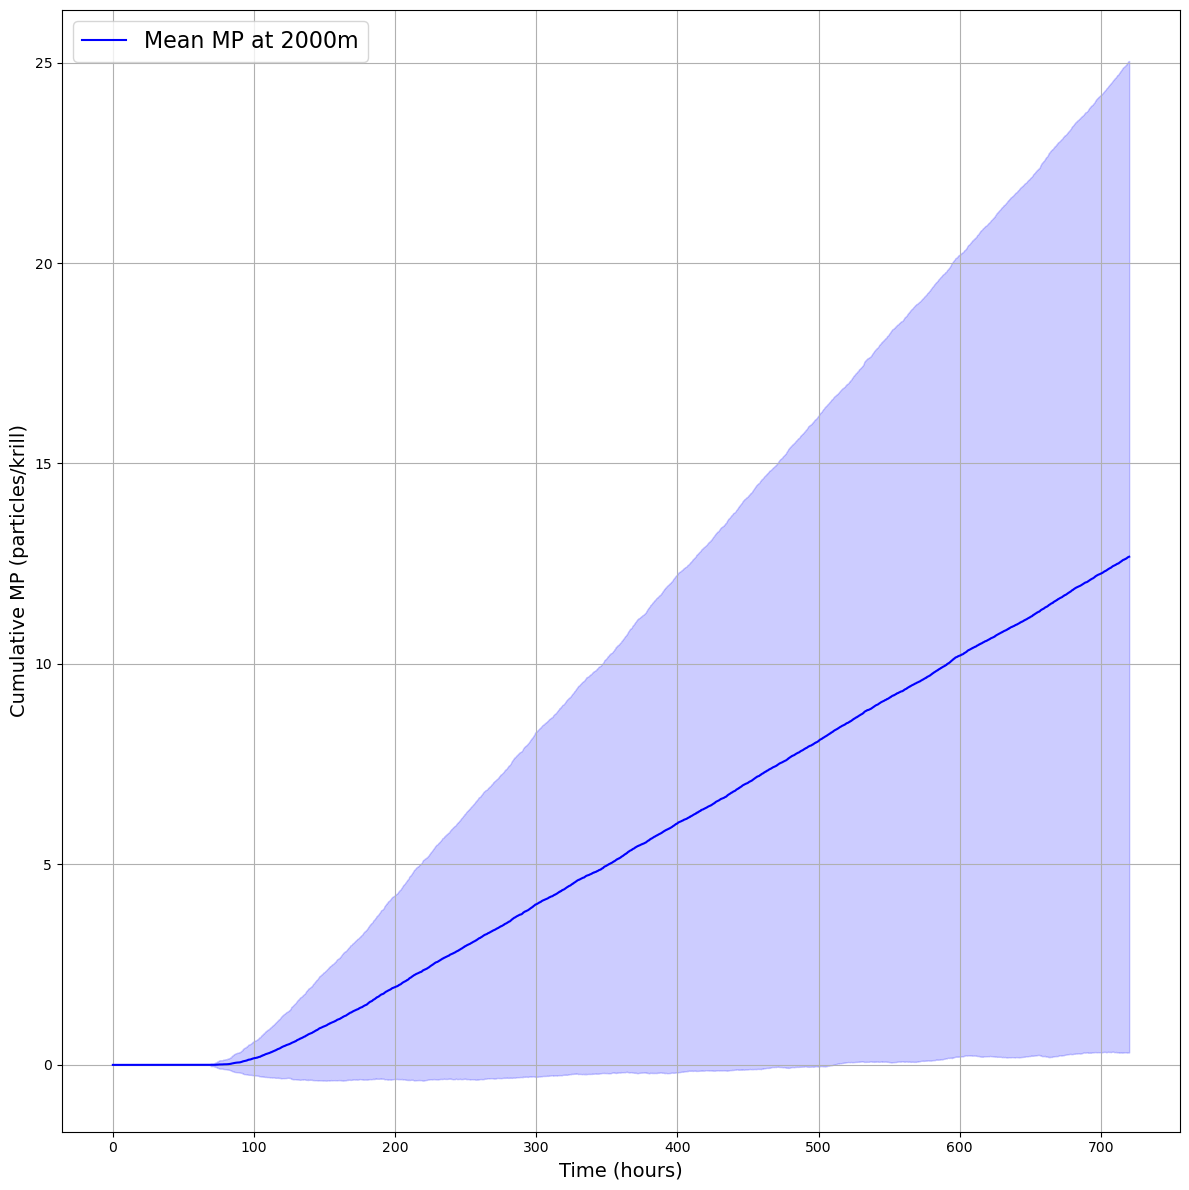

Average gradient between 400 and 700 hours: 0.020767928065754487


In [53]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(time, mean_acc, label="Mean MP at 2000m", color="blue")
ax.fill_between(
    time,
    mean_acc - std_acc,
    mean_acc + std_acc,
    color="blue", alpha=0.2
)

# ax.plot(time, mean_rise, label="Mean Rising MP", color="red")
# ax.fill_between(
#     time,
#     mean_rise - std_rise,
#     mean_rise + std_rise,
#     color="red", alpha=0.2
# )

ax.set_xlabel("Time (hours)", fontsize=14)
ax.set_ylabel("Cumulative MP (particles/krill)", fontsize=14)
ax.legend(fontsize=16)
ax.grid()

plt.tight_layout()
plt.show()

# Select the time indices between 400 and 700 hours
time_range = (time >= 400) & (time <= 700)
time_selected = time[time_range]
mean_acc_selected = mean_acc[time_range]

# Compute the gradient (rate of change) of the mean accumulation over time
gradient = np.gradient(mean_acc_selected, time_selected)

# Calculate the average gradient over the selected time interval
average_gradient = np.mean(gradient)
print(f"Average gradient between 400 and 700 hours: {average_gradient}")


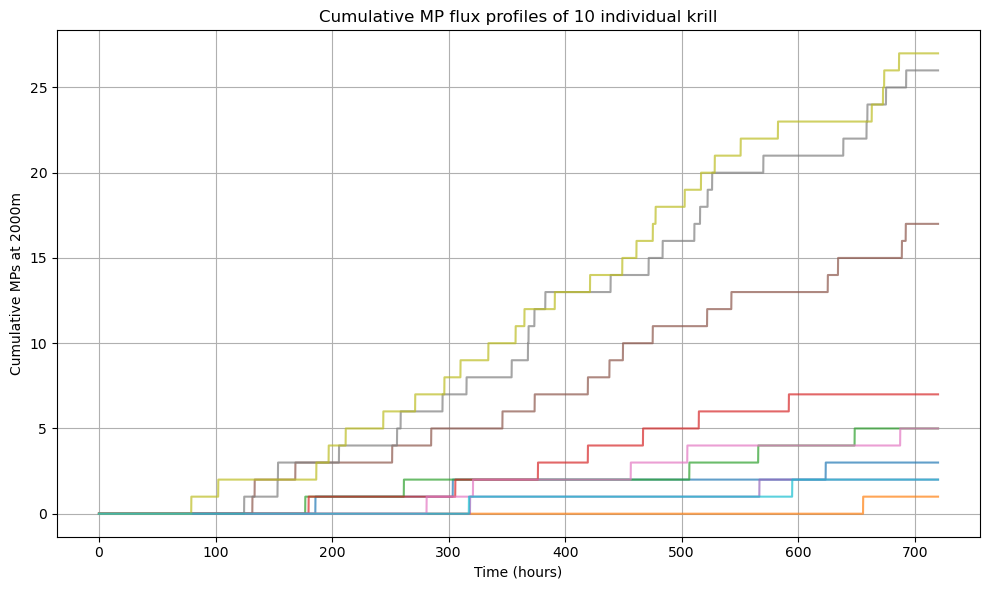

In [54]:
# Plot a few individual krill accumulation curves
plt.figure(figsize=(10, 6))

# Choose N random krill to plot (e.g., 10)
num_to_plot = 10
random_indices = np.random.choice(acc_cumsum.shape[0], num_to_plot, replace=False)

for idx in random_indices:
    plt.plot(time, acc_cumsum[idx], label=f'Krill {idx}', alpha=0.7)

plt.xlabel("Time (hours)")
plt.ylabel("Cumulative MPs at 2000m")
plt.title(f"Cumulative MP flux profiles of {num_to_plot} individual krill")
plt.grid(True)
plt.tight_layout()
plt.show()


## Different breaking chances

In [103]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# --- Simulation Parameters ---
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
b = -0.32
mu = 0.001
rho = 1025
gut_passage_time = 2
mp_conc = 1909.65
rho_p = 960
rho_data = pd.read_csv('rho_data.csv')

# Krill setup
num_simulations = 10
krill_per_sim = 40
krill_lengths = assign_krill_length(num_simulations * krill_per_sim)
krill_groups = krill_lengths.reshape((num_simulations, krill_per_sim))

# Proportions
num_above_10 = np.count_nonzero(krill_lengths > 10)
num_below_10 = np.count_nonzero(krill_lengths <= 10)
prop_above = num_above_10 / (num_above_10 + num_below_10)
prop_below = num_below_10 / (num_above_10 + num_below_10)

# Simulation function with break_chance param
def simulate_krill(krill_length, break_chance):
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    mp_accumulation_at_2000m = np.zeros_like(time)
    rising_mp = []

    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = np.full(num_pellets, 1050)
    mp_size = assign_mp_size(size=num_pellets)

    if krill_length > 18e-6:
        D = generate_random(183, 178, 450, 600, size=int(num_pellets * prop_above)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 100, size=int(num_pellets * prop_below)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < break_chance

    is_mp_pellet = np.zeros(num_pellets, dtype=bool)
    tolerance = gut_passage_time / 2

    for i in range(num_pellets):
        time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
        size_condition = (mp_size[i] < D[i])
        is_mp_pellet[i] = time_match and size_condition

    for i, release_time in enumerate(fp_release_times):
        if not is_mp_pellet[i]:
            continue
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                break

            idx_depth = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[idx_depth, 'Density'] * 1000
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L

            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True
                L /= 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt

        if reached_2000m and not mp_released:
            arrival_time = release_time + t
            idx = (np.abs(time - arrival_time)).argmin()
            mp_accumulation_at_2000m[idx] += 1

    return mp_accumulation_at_2000m

# Run for multiple break chances
break_chances_to_test = [0.2, 0.4, 0.6, 0.8]
results_all = []

for break_chance in break_chances_to_test:
    print(f"Running simulations for break chance {break_chance}")
    accum_all = np.zeros((num_simulations, len(time)))

    for sim_idx, krill_group in enumerate(krill_groups):
        results = Parallel(n_jobs=-1)(
            delayed(simulate_krill)(length, break_chance) for length in krill_group
        )
        acc_arrays = np.array(results)
        accum_all[sim_idx] = np.cumsum(np.sum(acc_arrays, axis=0))

    mean_acc = np.mean(accum_all, axis=0)
    std_acc = np.std(accum_all, axis=0)

    df = pd.DataFrame({
        'time_hours': time,
        f'mean_accum_{int(break_chance * 100)}': mean_acc,
        f'std_accum_{int(break_chance * 100)}': std_acc
    })
    results_all.append(df)

# Merge and save
final_df = results_all[0]
for df in results_all[1:]:
    final_df = final_df.merge(df, on='time_hours')

final_df.to_csv("microplastic_accumulation_by_breakchance.csv", index=False)
print("Saved to microplastic_accumulation_by_breakchance.csv")


Running simulations for break chance 0.2
Running simulations for break chance 0.4
Running simulations for break chance 0.6
Running simulations for break chance 0.8
Saved to microplastic_accumulation_by_breakchance.csv


In [104]:
final_df.head()

,time_hours,mean_accum_20,std_accum_20,mean_accum_40,std_accum_40,mean_accum_60,std_accum_60,mean_accum_80,std_accum_80
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.072007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.144014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.216022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.288029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


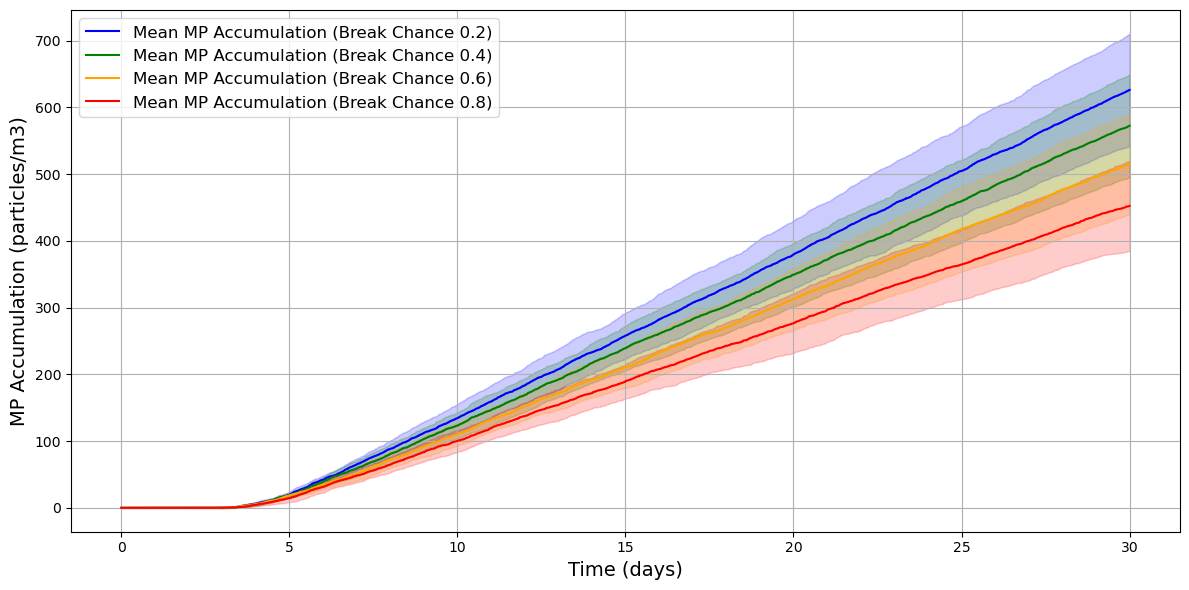

Average gradient of MP Accumulation (Break Chance 0.2) between 300 and 500 hours: 24.59842815988488 particles/m3/day
Average gradient of MP Accumulation (Break Chance 0.4) between 300 and 500 hours: 22.378028447964535 particles/m3/day
Average gradient of MP Accumulation (Break Chance 0.6) between 300 and 500 hours: 19.971595246668866 particles/m3/day
Average gradient of MP Accumulation (Break Chance 0.8) between 300 and 500 hours: 17.541157724162357 particles/m3/day


In [107]:
#plotting the results 
import pandas as pd
import matplotlib.pyplot as plt

#read in the csv
df = pd.read_csv("microplastic_accumulation_by_breakchance.csv")

#plotting the results
plt.figure(figsize=(12, 6))

plt.plot(df['time_hours']/24, df['mean_accum_20'], label='Mean MP Accumulation (Break Chance 0.2)', color='blue')
plt.fill_between(df['time_hours']/24, df['mean_accum_20'] - df['std_accum_20'], df['mean_accum_20'] + df['std_accum_20'], color='blue', alpha=0.2)
plt.plot(df['time_hours']/24, df['mean_accum_40'], label='Mean MP Accumulation (Break Chance 0.4)', color='green')
plt.fill_between(df['time_hours']/24, df['mean_accum_40'] - df['std_accum_40'], df['mean_accum_40'] + df['std_accum_40'], color='green', alpha=0.2)
plt.plot(df['time_hours']/24, df['mean_accum_60'], label='Mean MP Accumulation (Break Chance 0.6)', color='orange')
plt.fill_between(df['time_hours']/24, df['mean_accum_60'] - df['std_accum_60'], df['mean_accum_60'] + df['std_accum_60'], color='orange', alpha=0.2)
plt.plot(df['time_hours']/24, df['mean_accum_80'], label='Mean MP Accumulation (Break Chance 0.8)', color='red')
plt.fill_between(df['time_hours']/24, df['mean_accum_80'] - df['std_accum_80'], df['mean_accum_80'] + df['std_accum_80'], color='red', alpha=0.2)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('MP Accumulation (particles/m3)', fontsize=14)
#plt.title('Microplastic Accumulation at 2000m Depth by Break Chance', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Calculate the average gradient between 300 and 500 hours for each break chance
time_range = (df['time_hours'] >= 300) & (df['time_hours'] <= 500)
time_selected = df['time_hours'][time_range] / 24  # Convert to days
mean_acc_20 = df['mean_accum_20'][time_range]
mean_acc_40 = df['mean_accum_40'][time_range]
mean_acc_60 = df['mean_accum_60'][time_range]
mean_acc_80 = df['mean_accum_80'][time_range]

gradient_20 = np.gradient(mean_acc_20, time_selected)
average_gradient_20 = np.mean(gradient_20)
gradient_40 = np.gradient(mean_acc_40, time_selected)
average_gradient_40 = np.mean(gradient_40)
gradient_60 = np.gradient(mean_acc_60, time_selected)
average_gradient_60 = np.mean(gradient_60)
gradient_80 = np.gradient(mean_acc_80, time_selected)
average_gradient_80 = np.mean(gradient_80)

print(f"Average gradient of MP Accumulation (Break Chance 0.2) between 300 and 500 hours: {average_gradient_20} particles/m3/day")
print(f"Average gradient of MP Accumulation (Break Chance 0.4) between 300 and 500 hours: {average_gradient_40} particles/m3/day")
print(f"Average gradient of MP Accumulation (Break Chance 0.6) between 300 and 500 hours: {average_gradient_60} particles/m3/day")
print(f"Average gradient of MP Accumulation (Break Chance 0.8) between 300 and 500 hours: {average_gradient_80} particles/m3/day")


## Different times of year (eating different things therefore different densities)

In [ ]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)
from datetime import date


1054.8


In [2]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# --- Simulation Parameters ---
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# --- Prepare Krill Lengths for 1000 x 40 Simulations ---
num_simulations = 10
krill_per_sim = 40
krill_lengths = assign_krill_length(num_simulations * krill_per_sim)
krill_groups = krill_lengths.reshape((num_simulations, krill_per_sim))

# Calculate krill length proportions
num_krill_above_10 = np.count_nonzero(krill_lengths > 10)
num_krill_below_10 = np.count_nonzero(krill_lengths <= 10)
krill_length_proportion = num_krill_above_10 / (num_krill_above_10 + num_krill_below_10)
krill_length_proportion_bel = num_krill_below_10 / (num_krill_above_10 + num_krill_below_10)

# --- Simulation Function ---
def simulate_krill(krill_length, krill_length_proportion, krill_length_proportion_bel, seasonal_rho_s):

    

    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    mp_accumulation_at_2000m = np.zeros_like(time)
    rising_mp = []

    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = np.full(num_pellets, seasonal_rho_s)
    mp_size = assign_mp_size(size=num_pellets)

    if krill_length > 18e-6:
        D = generate_random(183, 178, 450, 600, size=int(num_pellets * krill_length_proportion)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 100, size=int(num_pellets * krill_length_proportion_bel)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    is_mp_pellet = np.zeros(num_pellets, dtype=bool)
    tolerance = gut_passage_time / 2

    for i in range(num_pellets):
        time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
        size_condition = (mp_size[i] < D[i])
        is_mp_pellet[i] = time_match and size_condition

    for i, release_time in enumerate(fp_release_times):
        if not is_mp_pellet[i]:
            continue
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                break

            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L

            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True
                L /= 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt

        if reached_2000m and not mp_released:
            arrival_time = release_time + t
            idx = (np.abs(time - arrival_time)).argmin()
            mp_accumulation_at_2000m[idx] += 1

    return mp_accumulation_at_2000m, rising_mp

import datetime

# Define seasonal dates
seasonal_dates = {
    'Spring': datetime.date(2023, 10, 1),
    'Summer': datetime.date(2023, 1, 1),
    'Autumn': datetime.date(2023, 3, 1)
}

# Store results for each season
seasonal_results = {}

for season, date in seasonal_dates.items():
    print(f"\nRunning simulations for {season}...")

    # Calculate seasonal FP density
    seasonal_rho_s = calculate_fp_density(date)

    # Storage for all simulations in this season
    total_accum_all = np.zeros((num_simulations, len(time)))

    for sim_idx, krill_group in enumerate(krill_groups):
        print(f"  Simulation {sim_idx + 1}/{num_simulations}...")

        results = Parallel(n_jobs=-1)(
            delayed(simulate_krill)(
                length, krill_length_proportion, krill_length_proportion_bel, seasonal_rho_s
            )
            for length in krill_group
        )

        acc_arrays = np.array([acc for acc, _ in results])
        total_accum = np.sum(acc_arrays, axis=0)
        total_accum_all[sim_idx] = np.cumsum(total_accum)

    # Store mean and std accumulation
    seasonal_results[season] = {
        'mean': np.mean(total_accum_all, axis=0),
        'std': np.std(total_accum_all, axis=0)
    }





Running simulations for Spring...
  Simulation 1/10...
  Simulation 2/10...
  Simulation 3/10...
  Simulation 4/10...
  Simulation 5/10...
  Simulation 6/10...
  Simulation 7/10...
  Simulation 8/10...
  Simulation 9/10...
  Simulation 10/10...

Running simulations for Summer...
  Simulation 1/10...
  Simulation 2/10...
  Simulation 3/10...
  Simulation 4/10...
  Simulation 5/10...
  Simulation 6/10...
  Simulation 7/10...
  Simulation 8/10...
  Simulation 9/10...
  Simulation 10/10...

Running simulations for Autumn...
  Simulation 1/10...
  Simulation 2/10...
  Simulation 3/10...
  Simulation 4/10...
  Simulation 5/10...
  Simulation 6/10...
  Simulation 7/10...
  Simulation 8/10...
  Simulation 9/10...
  Simulation 10/10...


In [3]:
import pandas as pd
# Save results to CSV
seasonal_df = pd.DataFrame({
    'Time (hours)': time,
    'Spring Mean': seasonal_results['Spring']['mean'],
    'Spring Std': seasonal_results['Spring']['std'],
    'Summer Mean': seasonal_results['Summer']['mean'],
    'Summer Std': seasonal_results['Summer']['std'],
    'Autumn Mean': seasonal_results['Autumn']['mean'],
    'Autumn Std': seasonal_results['Autumn']['std']
})
seasonal_df.to_csv("krill_mp_accumulation_seasonal_stats.csv", index=False)
print("Seasonal mean and standard deviation saved to 'krill_mp_accumulation_seasonal_stats.csv'")


Seasonal mean and standard deviation saved to 'krill_mp_accumulation_seasonal_stats.csv'


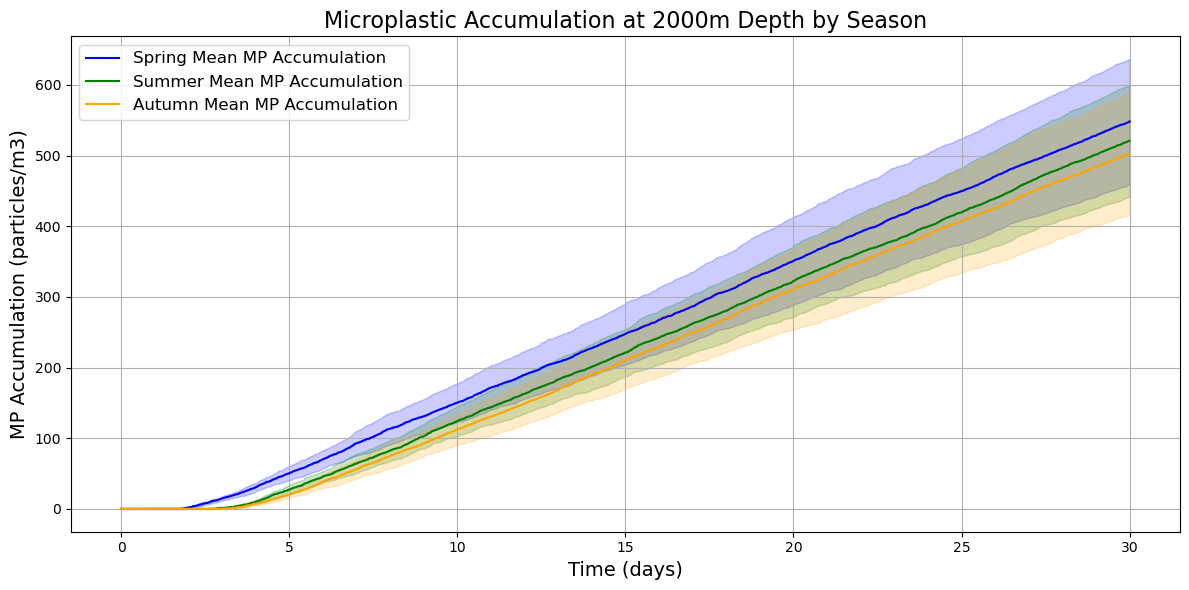

Average gradient of MP Accumulation (Spring) between 300 and 500 hours: 20.319657904213102 particles/m3/day
Average gradient of MP Accumulation (Summer) between 300 and 500 hours: 20.031606049693693 particles/m3/day
Average gradient of MP Accumulation (Autumn) between 300 and 500 hours: 20.21163845876813 particles/m3/day


In [4]:
#plot results 

#import csv
seasonal_df = pd.read_csv("krill_mp_accumulation_seasonal_stats.csv")

#plotting the results
plt.figure(figsize=(12, 6))
plt.plot(seasonal_df['Time (hours)']/24, seasonal_df['Spring Mean'], label='Spring Mean MP Accumulation', color='blue')
plt.fill_between(seasonal_df['Time (hours)']/24, seasonal_df['Spring Mean'] - seasonal_df['Spring Std'], seasonal_df['Spring Mean'] + seasonal_df['Spring Std'], color='blue', alpha=0.2)
plt.plot(seasonal_df['Time (hours)']/24, seasonal_df['Summer Mean'], label='Summer Mean MP Accumulation', color='green')
plt.fill_between(seasonal_df['Time (hours)']/24, seasonal_df['Summer Mean'] - seasonal_df['Summer Std'], seasonal_df['Summer Mean'] + seasonal_df['Summer Std'], color='green', alpha=0.2)
plt.plot(seasonal_df['Time (hours)']/24, seasonal_df['Autumn Mean'], label='Autumn Mean MP Accumulation', color='orange')
plt.fill_between(seasonal_df['Time (hours)']/24, seasonal_df['Autumn Mean'] - seasonal_df['Autumn Std'], seasonal_df['Autumn Mean'] + seasonal_df['Autumn Std'], color='orange', alpha=0.2)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('MP Accumulation (particles/m3)', fontsize=14)
plt.title('Microplastic Accumulation at 2000m Depth by Season', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
# Calculate the average gradient between 300 and 500 hours for each season
time_range = (seasonal_df['Time (hours)'] >= 300) & (seasonal_df['Time (hours)'] <= 500)
time_selected = seasonal_df['Time (hours)'][time_range] / 24  # Convert to days
spring_mean = seasonal_df['Spring Mean'][time_range]
spring_std = seasonal_df['Spring Std'][time_range]
summer_mean = seasonal_df['Summer Mean'][time_range]
summer_std = seasonal_df['Summer Std'][time_range]
autumn_mean = seasonal_df['Autumn Mean'][time_range]
autumn_std = seasonal_df['Autumn Std'][time_range]

gradient_spring = np.gradient(spring_mean, time_selected)
average_gradient_spring = np.mean(gradient_spring)
gradient_summer = np.gradient(summer_mean, time_selected)
average_gradient_summer = np.mean(gradient_summer)
gradient_autumn = np.gradient(autumn_mean, time_selected)
average_gradient_autumn = np.mean(gradient_autumn)
print(f"Average gradient of MP Accumulation (Spring) between 300 and 500 hours: {average_gradient_spring} particles/m3/day")
print(f"Average gradient of MP Accumulation (Summer) between 300 and 500 hours: {average_gradient_summer} particles/m3/day")
print(f"Average gradient of MP Accumulation (Autumn) between 300 and 500 hours: {average_gradient_autumn} particles/m3/day")


# different surface ocean concentrations

In [100]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# --- Parameters ---
depth_limit = 2000
time = np.linspace(0, 720, 10000)
b = -0.32
mu = 0.001
rho = 1025
gut_passage_time = 2
rho_p = 960
surface_concs = [1900, 950, 475]

rho_data = pd.read_csv('rho_data.csv')

num_simulations = 10
krill_per_sim = 40

krill_lengths = assign_krill_length(num_simulations * krill_per_sim)
krill_groups = krill_lengths.reshape((num_simulations, krill_per_sim))

# Krill length proportions
num_above_10 = np.count_nonzero(krill_lengths > 10)
num_below_10 = np.count_nonzero(krill_lengths <= 10)
prop_above = num_above_10 / (num_above_10 + num_below_10)
prop_below = num_below_10 / (num_above_10 + num_below_10)

def simulate_krill(krill_length, mp_conc):
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    mp_accumulation_at_2000m = np.zeros_like(time)
    rising_mp = []

    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = np.full(num_pellets, 1050)
    mp_size = assign_mp_size(size=num_pellets)

    if krill_length > 18e-6:
        D = generate_random(183, 178, 450, 600, size=int(num_pellets * prop_above)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 100, size=int(num_pellets * prop_below)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    is_mp_pellet = np.zeros(num_pellets, dtype=bool)
    tolerance = gut_passage_time / 2

    for i in range(num_pellets):
        time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
        size_condition = (mp_size[i] < D[i])
        is_mp_pellet[i] = time_match and size_condition

    for i, release_time in enumerate(fp_release_times):
        if not is_mp_pellet[i]:
            continue
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                break

            idx_depth = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[idx_depth, 'Density'] * 1000
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L

            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True
                L /= 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt

        if reached_2000m and not mp_released:
            arrival_time = release_time + t
            idx = (np.abs(time - arrival_time)).argmin()
            mp_accumulation_at_2000m[idx] += 1

    return mp_accumulation_at_2000m

# Store results for all concentrations
all_results = []

for conc in surface_concs:
    print(f"Running simulations for concentration {conc} particles/m³...")
    accum_all = np.zeros((num_simulations, len(time)))

    for sim_idx, krill_group in enumerate(krill_groups):
        results = Parallel(n_jobs=-1)(
            delayed(simulate_krill)(length, conc) for length in krill_group
        )
        acc_arrays = np.array(results)
        accum_all[sim_idx] = np.cumsum(np.sum(acc_arrays, axis=0))

    mean_acc = np.mean(accum_all, axis=0)
    std_acc = np.std(accum_all, axis=0)

    df = pd.DataFrame({
        'time_hours': time,
        f'mean_accum_{conc}': mean_acc,
        f'std_accum_{conc}': std_acc
    })
    all_results.append(df)

# Merge and Save
merged_df = all_results[0]
for df in all_results[1:]:
    merged_df = merged_df.merge(df, on='time_hours')

merged_df.to_csv("microplastic_accumulation_three_concs.csv", index=False)
print("Results saved to microplastic_accumulation_three_concs.csv")


Running simulations for concentration 1900 particles/m³...
Running simulations for concentration 950 particles/m³...
Running simulations for concentration 475 particles/m³...
Results saved to microplastic_accumulation_three_concs.csv


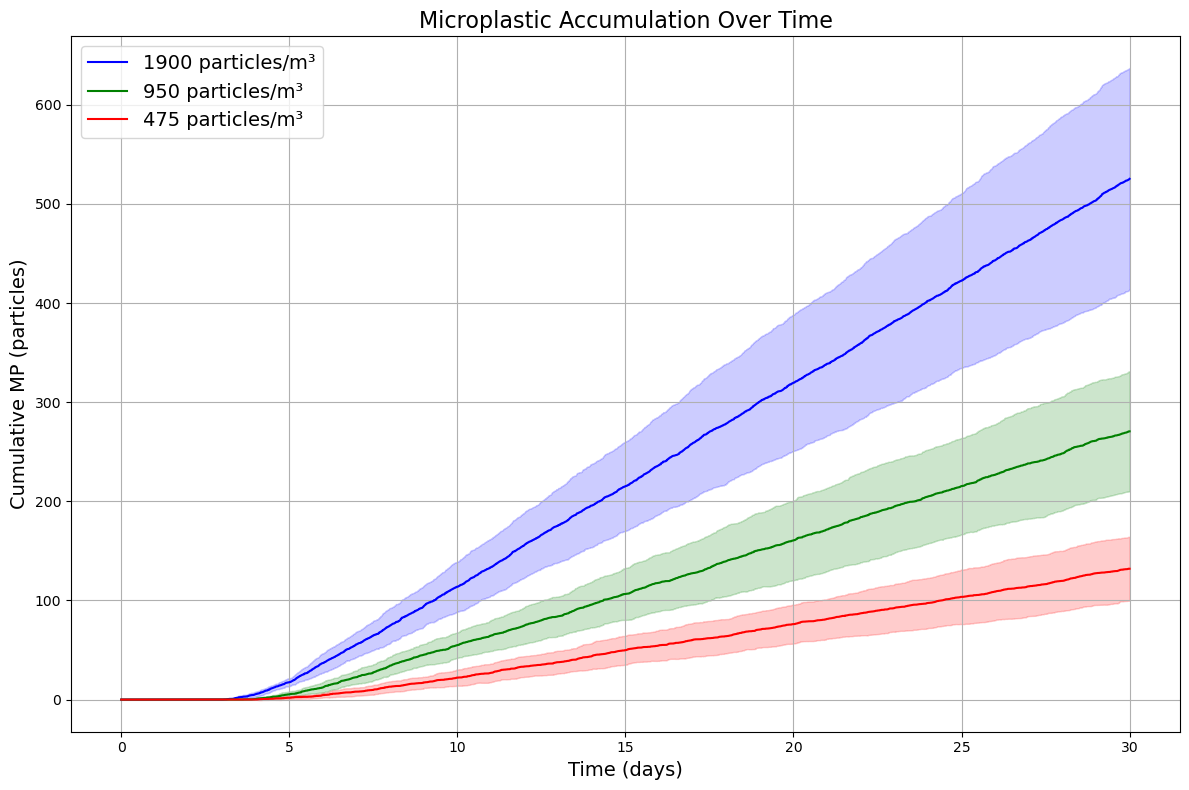

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the results from the CSV file
mp_df = pd.read_csv("microplastic_accumulation_three_concs.csv")

# Define the concentrations and colors for plotting
concentrations = [1900, 950, 475]
colors = ['blue', 'green', 'red']


# Plotting
plt.figure(figsize=(12, 8))

for i, conc in enumerate(concentrations):
    plt.plot(mp_df['time_hours']/24, mp_df[f'mean_accum_{conc}'], label=f"{conc} particles/m³", color=colors[i])
    plt.fill_between(mp_df['time_hours']/24,
                     mp_df[f'mean_accum_{conc}'] - mp_df[f'std_accum_{conc}'],
                     mp_df[f'mean_accum_{conc}'] + mp_df[f'std_accum_{conc}'],
                     color=colors[i], alpha=0.2)
plt.xlabel("Time (days)", fontsize=14)    
plt.ylabel("Cumulative MP (particles)", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.tight_layout()
plt.show()


# chaning ocean surface concentration

In [ ]:
krill_summary = pd.read_csv('krill_summary.csv')
krill_summary_filt = krill_summary.dropna(subset=['mean_standardised'])

mean = krill_summary_filt['mean_standardised'].mean()
print(mean)

17.383359198380376


In [4]:
#south georgia because there are a lot of krill here and probably a lot of microplastics

import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

#import krill_summary csv
krill_summary = pd.read_csv('krill_summary.csv')

# #extract the south georgia data -> 32-40W and 52-48S
# south_georgia_krill = krill_summary[
#     (krill_summary['lat_bins'] == '(-58, -54]')]# & 
#     # (krill_summary['long_bins'] == '(-44, -36]') &
#     # (krill_summary['long_bins'] == '(-36, -28]')]

#extract rows 377 and 378 from krill_summary
south_georgia_krill = krill_summary.iloc[377:379]

#number of MP
volume_water_km3 = 221109.705459 * 2 * 0.1 #km3
volume_water = volume_water_km3 * 1e9 #m3
mp_conc = 1909.65 #particles/m3
num_mp = volume_water * mp_conc
print(num_mp)
print(south_georgia_krill)




8.444842980595587e+16
       lat_bins   long_bins  mean_standardised       Area_km2      no_krill  \
377  (-58, -54]  (-44, -36]         161.407604  221109.705459  3.568879e+07   
378  (-58, -54]  (-36, -28]         172.265000  221109.705459  3.808946e+07   

     MP_removal_one_month  
377          8.922197e+07  
378          9.522366e+07  


In [ ]:
##Actually more efficient main code!

import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length
)

# Simulation Parameters
depth_limit = 310  # m
time = np.linspace(0, 720, 100000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# Get krill lengths
krill_lengths = assign_krill_length(17*10)

#calculate proportion of krill_length > 10

num_krill_above_10 = np.count_nonzero(krill_lengths > 10)
num_krill_below_10 = np.count_nonzero(krill_lengths <= 10)
krill_length_proportion = num_krill_above_10 / (num_krill_above_10 + num_krill_below_10)
krill_length_proportion_bel = num_krill_below_10 / (num_krill_above_10 + num_krill_below_10)

def simulate_krill(krill_length, krill_length_proportion, krill_length_proportion_bel):
    """Simulates one krill's impact on microplastic flux."""
    
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize accumulation arrays
    mp_accumulation_at_310m = np.zeros_like(time)
    pellets_reaching_310m = 0
    rising_mp = []

    # Precompute random variables
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
    mp_size = assign_mp_size(size=num_pellets)

    # making the widths of the pellets slighly dependent on the krill length
    if krill_length > 18e-6:
        D = generate_random(183, 178, 200, 600, size= int(num_pellets * krill_length_proportion)) * 1e-6
    else:
        D = generate_random(183, 178, 80, 400, size= int(num_pellets * krill_length_proportion_bel)) * 1e-6

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.63

    # Simulate sinking for each fecal pellet
    for i, release_time in enumerate(fp_release_times):
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_310m = False
        mp_released = False
        broke = False
        

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_310m = True
                pellets_reaching_310m += 1
                break
            
            # Update density based on depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L


            # Breakage handling
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  
                L /= 2 # Break length in half
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))
                else:
                    mp_released = False
            
            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt  # Convert to hourly movement

        if reached_310m and not mp_released:
            index = (np.abs(time - (release_time + t))).argmin()
            mp_accumulation_at_310m[index] += 1
    
    return mp_accumulation_at_310m, rising_mp


# ** Run Parallel Simulations **
results = Parallel(n_jobs=-1)(delayed(simulate_krill)(length, krill_length_proportion, krill_length_proportion_bel) for length in krill_lengths)

# Aggregate results
mp_accumulation_at_310m = np.zeros_like(time)
rising_mp = []

for acc, rising in results:
    mp_accumulation_at_310m += acc
    rising_mp.extend(rising)

# Simulate rising microplastics
mp_rising_accumulation = np.zeros_like(time)
counted_indices = set()

for depth, release_time, wr in rising_mp:
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time

    for t in time_since_release:
        if depth <= 100:
            index = (np.abs(time - (release_time + t))).argmin()
            if index not in counted_indices:
                mp_rising_accumulation[index] += 1
                counted_indices.add(index)
            break
        depth -= wr * (time[1] - time[0])

mp_rising_accumulation = np.cumsum(mp_rising_accumulation)
mp_accumulation_at_310m = np.cumsum(mp_accumulation_at_310m)
mp_surface_removal = mp_accumulation_at_310m - mp_rising_accumulation



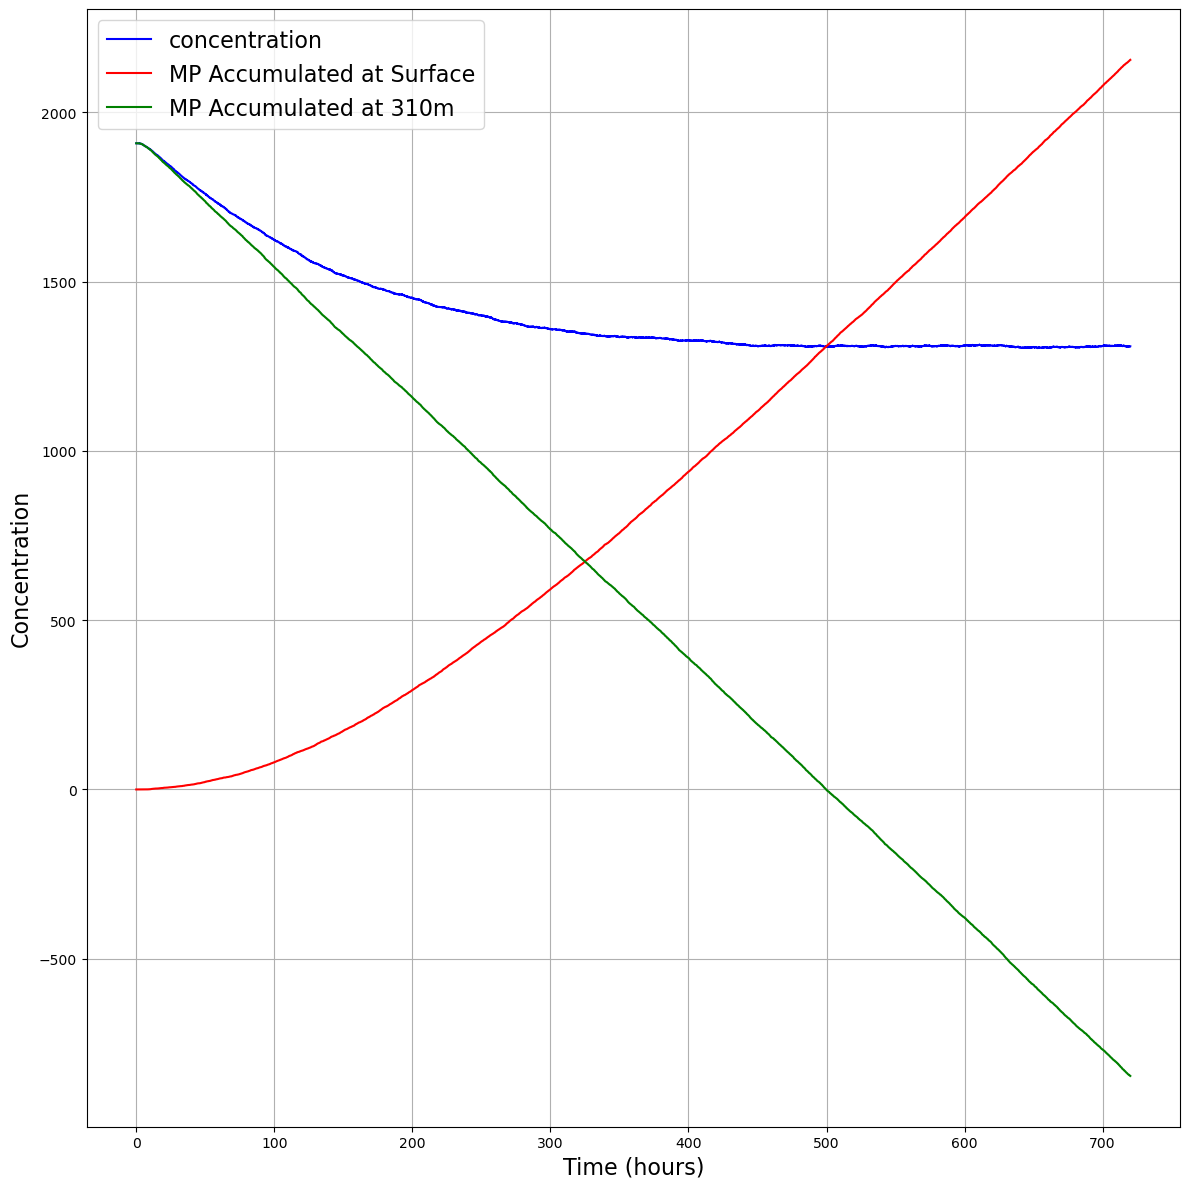

Average gradient of MP surface removal between 300 and 500 hours: 2.5500459012855


In [31]:
# Plot Results
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 12), sharex=True)

axes.plot(time, (1909*10 - mp_surface_removal)/10, color='blue', label = 'concentration')
axes.plot(time, mp_rising_accumulation/10, color='red', label = "MP Accumulated at Surface")
axes.plot(time, (1909*10 - mp_accumulation_at_310m)/10, color='green', label = "MP Accumulated at 310m")
axes.set_xlabel("Time (hours)", fontsize=16)
axes.set_ylabel("Concentration", fontsize=16)
axes.grid()
axes.legend(fontsize=16)

plt.tight_layout()
plt.show()

# Approximate the gradient between 300 and 500 hours
time_range = (time >= 300) & (time <= 500)
time_selected = time[time_range]

# Gradient for MP Accumulated at 2000m
mp_surface_removal_gradient = np.gradient(mp_surface_removal[time_range], time_selected)
average_gradient_surface_removal = np.mean(mp_surface_removal_gradient)

print(f"Average gradient of MP surface removal between 300 and 500 hours: {average_gradient_surface_removal}")





In [83]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length, calculate_fp_density
)

# Simulation Parameters
depth_limit = 2000  # m
time = np.linspace(0, 720, 10000)  # Simulation time in hours
surface_layer_depth = 100  # Surface ocean layer (0–100m)
initial_surface_conc = 1900  # Initial microplastic concentration (particles/m³)
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
rho_p = 960  # Density of microplastic kg/m³

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

def simulate_group_of_krill():
    krill_lengths = assign_krill_length(40)
    surface_concentration = np.full_like(time, initial_surface_conc, dtype=float)
    egested_mp = np.zeros_like(time)
    rising_mp = np.zeros_like(time)

    for krill_length in krill_lengths:
        clearance_rate = calc_clearance_rate(krill_length)
        krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, initial_surface_conc)
        time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

        fp_release_times = np.arange(0, max(time), time_produce_one_mp_fp)
        num_pellets = len(fp_release_times)
        mp_size = assign_mp_size(size=num_pellets)

        for release_time in fp_release_times:
            idx_release = np.abs(time - release_time).argmin()
            egested_mp[idx_release] += 1

            if np.random.rand() < 0.37:  # Assume 37% rise
                wr = calc_rising_velocity(np.mean(mp_size), rho_p, rho, mu) / 24
                rise_time = surface_layer_depth / wr
                idx_rise = np.abs(time - (release_time + rise_time)).argmin()
                rising_mp[idx_rise] += 1

    for i in range(1, len(time)):
        surface_concentration[i] = surface_concentration[i-1] - egested_mp[i] + rising_mp[i]

    return surface_concentration

n_groups = 10
group_results = Parallel(n_jobs=-1)(delayed(simulate_group_of_krill)() for _ in range(n_groups))

group_results = np.array(group_results)  # shape: (1000, len(time))

mean_surface_conc = np.mean(group_results, axis=0)
std_surface_conc = np.std(group_results, axis=0)


# Create a DataFrame to store the time, mean, and standard deviation
df_results = pd.DataFrame({
    'Time (hours)': time,
    'Mean Surface Concentration': mean_surface_conc,
    'Std Surface Concentration': std_surface_conc
})

# Save the DataFrame to a CSV file
df_results.to_csv('krill_surface_concentration_results.csv', index=False)


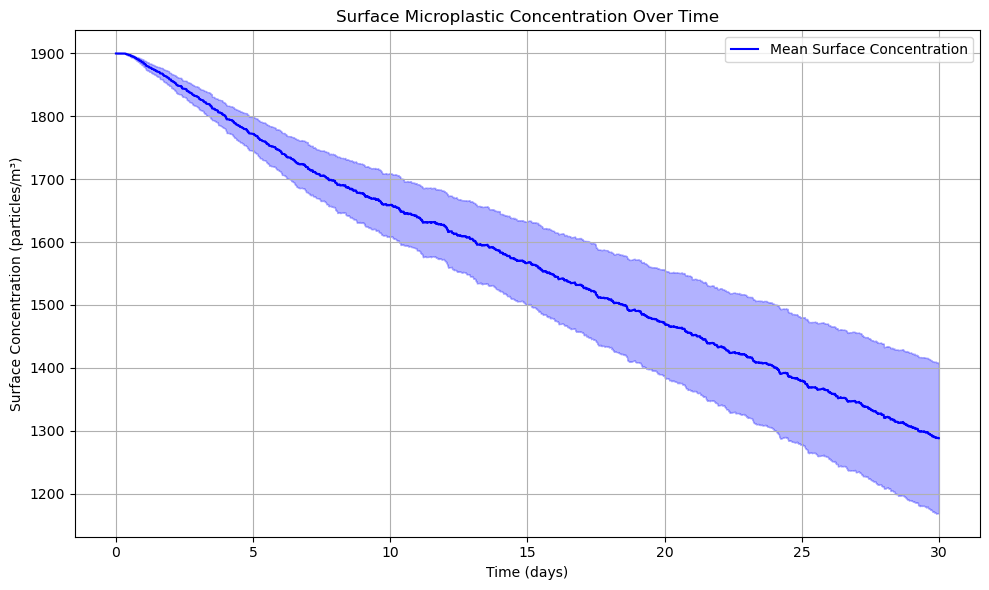

Average gradient of mean surface concentration between 300 and 500 hours: -18.35130356499836 per day
Average gradient of mean surface concentration between 40 and 110 hours: -29.18089506172768 per day


In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from the CSV file
df_results = pd.read_csv('krill_surface_concentration_results.csv')

#delete the last row of the dataframe
df_results = df_results[:-1]

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot the mean surface concentration
plt.plot(df_results['Time (hours)']/24, df_results['Mean Surface Concentration'], label='Mean Surface Concentration', color='blue')
plt.fill_between(df_results['Time (hours)']/24, 
                 df_results['Mean Surface Concentration'] - df_results['Std Surface Concentration'], 
                 df_results['Mean Surface Concentration'] + df_results['Std Surface Concentration'], 
                 alpha=0.3, color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Surface Concentration (particles/m³)')
plt.title('Surface Microplastic Concentration Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#gradient of the mean surface concentration between 300 and 500 hours
time_range = (df_results['Time (hours)'] >= 300) & (df_results['Time (hours)'] <= 500)
time_selected = df_results['Time (hours)'][time_range]
mean_surface_conc_gradient = np.gradient(df_results['Mean Surface Concentration'][time_range], time_selected)
average_gradient_surface_conc = np.mean(mean_surface_conc_gradient) * 24  # Convert to per day
print(f"Average gradient of mean surface concentration between 300 and 500 hours: {average_gradient_surface_conc} per day")

#gradient between 40 and 110 hours
time_range = (df_results['Time (hours)'] >= 40) & (df_results['Time (hours)'] <= 110)
time_selected = df_results['Time (hours)'][time_range]
mean_surface_conc_gradient = np.gradient(df_results['Mean Surface Concentration'][time_range], time_selected)
average_gradient_surface_conc = np.mean(mean_surface_conc_gradient) * 24
print(f"Average gradient of mean surface concentration between 40 and 110 hours: {average_gradient_surface_conc} per day")



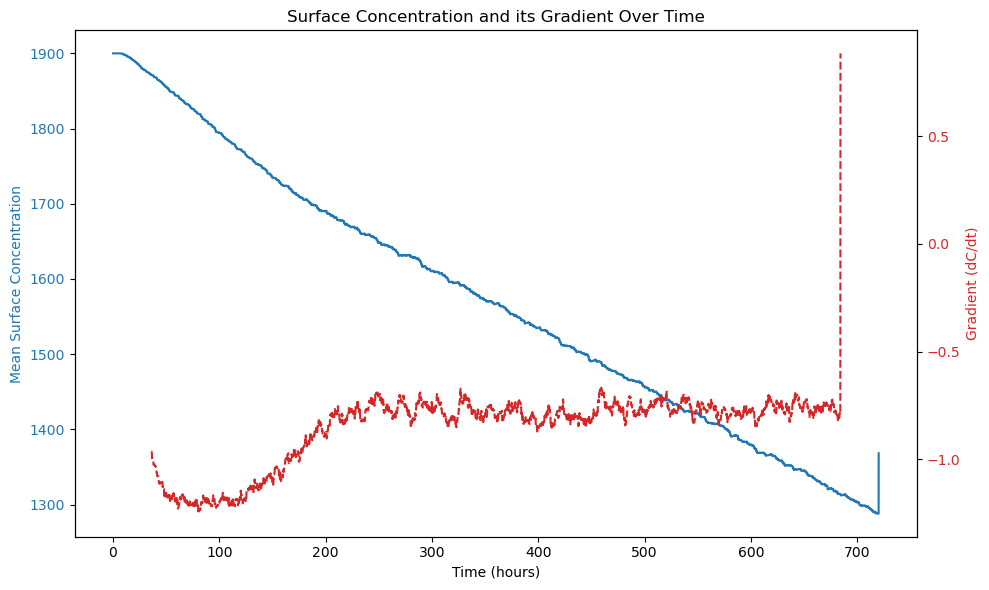

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to pandas Series for rolling
mean_series = pd.Series(mean_surface_conc)

# Apply rolling average
smoothed_mean = mean_series.rolling(window=100, center=True).mean()


# Compute the gradient of the mean surface concentration
gradient = np.gradient(mean_surface_conc, time)

# Optional: smooth gradient using a rolling average to reduce noise
window = 1000  # you can adjust this
smoothed_gradient = pd.Series(gradient).rolling(window=window, center=True).mean()

# Plot surface concentration and its gradient
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mean Surface Concentration', color=color)
ax1.plot(time, mean_surface_conc, color=color, label='Surface Concentration')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second y-axis
color = 'tab:red'
ax2.set_ylabel('Gradient (dC/dt)', color=color)
ax2.plot(time, smoothed_gradient, color=color, linestyle='--', label='Gradient')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Surface Concentration and its Gradient Over Time')
fig.tight_layout()
plt.show()


# FIGURE - Changing parameters 

In [ ]:
#plotting all three in the same figure 

# FIGURE 2 - surface ocean conc and accumulation at depth


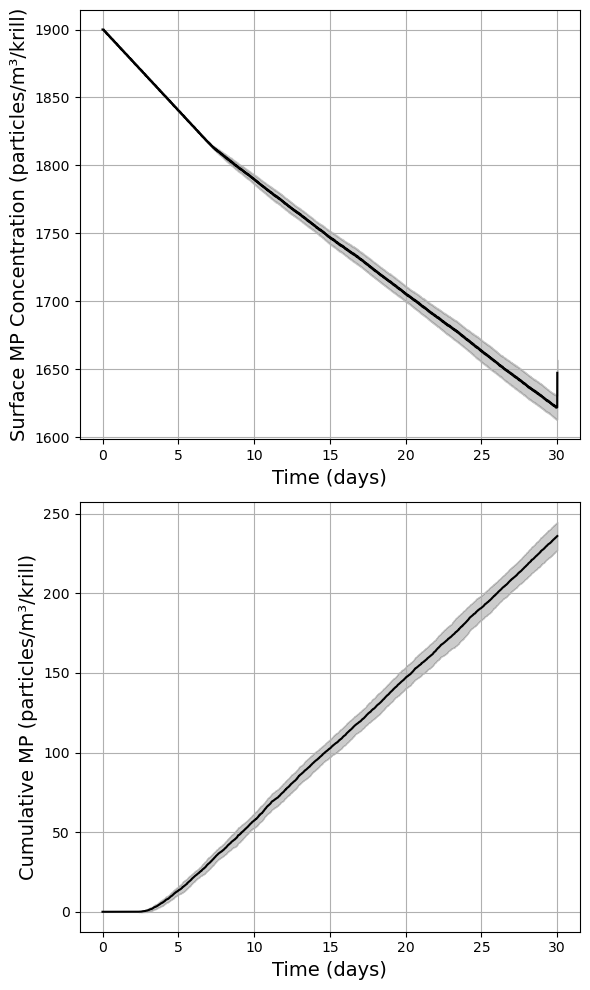

In [10]:
#import the csvs
mean_std_df = pd.read_csv('mean_std_surface_concentration.csv')
mean_surface_conc = mean_std_df['Mean_Surf_conc'].values
std_surface_conc = mean_std_df['Std_Surf_conc'].values

mean_std_df_deep = pd.read_csv('mean_std_accumulation_2000m.csv')
mean_acc = mean_std_df_deep['Mean_Accumulation'].values
std_acc = mean_std_df_deep['Std_Accumulation'].values

# Plotting
fig, ax = plt.subplots(2,1, figsize=(6, 10))

#convert time to days
time = time / 24

ax[0].plot(time, mean_surface_conc, label="Mean Surface MP Concentration", color="black")
ax[0].fill_between(
    time,
    mean_surface_conc - std_surface_conc,
    mean_surface_conc + std_surface_conc,
    color="black", alpha=0.2
)
ax[0].set_xlabel("Time (days)", fontsize=14)
ax[0].set_ylabel("Surface MP Concentration (particles/m³/krill)", fontsize=14)
ax[0].grid()

ax[1].plot(time, mean_acc, label="Mean MP at 2000m", color="black")
ax[1].fill_between(
    time,
    mean_acc - std_acc,
    mean_acc + std_acc,
    color="black", alpha=0.2
)


ax[1].set_xlabel("Time (days)", fontsize=14)
ax[1].set_ylabel("Cumulative MP (particles/m³/krill)", fontsize=14)
#ax[1].legend(fontsize=16)
ax[1].grid()

plt.tight_layout()
plt.show()



In [13]:
import numpy as np

# Assuming 'time' is already defined and matches the shape of the data
time = mean_std_df['Time'].values  # or however your time array is defined
time = time / 24  # Convert time to days
# Find the indices for the 300 to 600 hour window
mask = (time >= 15) & (time <= 25)

# Subset the time and data arrays
time_subset = time[mask]
surf_subset = mean_surface_conc[mask]
deep_subset = mean_acc[mask]

# Compute gradients using linear fit (more stable than np.gradient for noisy data)
surf_gradient = np.polyfit(time_subset, surf_subset, 1)[0]
deep_gradient = np.polyfit(time_subset, deep_subset, 1)[0]

print(f"Gradient of surface mean concentration between 300-600 hrs: {surf_gradient:.4f} particles/m³ per hour")
print(f"Gradient of deep accumulation between 300-600 hrs: {deep_gradient:.4f} particles/krill per hour")


Gradient of surface mean concentration between 300-600 hrs: -8.3655 particles/m³ per hour
Gradient of deep accumulation between 300-600 hrs: 8.8855 particles/krill per hour


In [14]:
import numpy as np

# Assuming 'time' is already defined and matches the shape of the data
time = mean_std_df['Time'].values  # or however your time array is defined
time = time / 24  # Convert time to days

# Find the indices for the 300 to 600 hour window
mask = (time >= 0.1) & (time <= 5)

# Subset the time and data arrays
time_subset = time[mask]
surf_subset = mean_surface_conc[mask]

# Compute gradients using linear fit (more stable than np.gradient for noisy data)
surf_gradient = np.polyfit(time_subset, surf_subset, 1)[0]

print(f"Gradient of surface mean concentration between 0-100 hrs: {surf_gradient:.4f} particles/m³ per hour")



Gradient of surface mean concentration between 0-100 hrs: -11.9987 particles/m³ per hour


# Map plotting

In [119]:
#importing the krillbase data
import pandas as pd
import numpy as np

# Load the data
krillbase = pd.read_csv("krillbase/krillbase_data.csv", encoding="ISO-8859-1")

# Replace non-numeric entries in 'STANDARDISED_KRILL_UNDER_1M2' column with NaN
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = pd.to_numeric(krillbase['STANDARDISED_KRILL_UNDER_1M2'], errors='coerce')

# Drop rows where 'STANDARDISED_KRILL_UNDER_1M2' is NaN
krillbase = krillbase.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2'])

# Round the values to 2 decimal places to reduce uniqueness
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = krillbase['STANDARDISED_KRILL_UNDER_1M2'].round(2)

# Create latitude and longitude bins
latitude_bins = np.arange(-90, 90 + 4, 4)
longitude_bins = np.arange(-180, 180 + 8, 8)

# Create the binning and label each row
krillbase['lat_bins'] = pd.cut(krillbase['LATITUDE'], bins=latitude_bins)
krillbase['long_bins'] = pd.cut(krillbase['LONGITUDE'], bins=longitude_bins)

# Function to calculate the area of a bin (in square km)
def calculate_area(lat_bin, long_bin):
    # Get the bin edges
    lat_min = lat_bin.left
    lat_max = lat_bin.right
    long_min = long_bin.left
    long_max = long_bin.right
    
    # Approximate length of one degree of latitude in km (approximately 111 km)
    lat_length = 111  # km
    
    # Calculate the average latitude to account for the varying size of longitude
    avg_lat = (lat_min + lat_max) / 2
    # Length of one degree of longitude in km at the average latitude
    long_length = 111.32 * np.cos(np.radians(avg_lat))  # km
    
    # Area of the bin: width (longitude) * height (latitude)
    area = lat_length * (lat_max - lat_min) * long_length * (long_max - long_min)
    return area

# Apply the calculate_area function to each row
krillbase['Area_km2'] = krillbase.apply(lambda row: calculate_area(row['lat_bins'], row['long_bins']), axis=1)



#add a column with the average standardised krill under 1m2 in each bin
krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')


# Now, create a new DataFrame that only contains the bins and total number of krill for each bin
krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['mean_standardised'].mean().reset_index()

krill_summary['Area_km2'] = krill_summary.apply(lambda row: calculate_area(row['lat_bins'], row['long_bins']), axis=1)


krill_summary['no_krill'] = krill_summary['mean_standardised'] * krill_summary['Area_km2']

krill_summary['MP_removal_one_month'] = krill_summary['no_krill'] * 0.45 * 30

krill_summary['conc_change_month'] = 1900 - krill_summary['no_krill'] * 0.45 * 30 / (krill_summary['Area_km2']) #convert km2 to m2


# Display the summary DataFrame

#reset index
krill_summary.reset_index(drop=True, inplace=True)

print(list(krill_summary.mean_standardised))


krill_summary
#save krill_summary
krill_summary.to_csv('krill_summary.csv', index=False)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.028125, 0.355, 0.0, 0.4975, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0, 0.0, 0.0, 0.17666666666666667, nan, nan, 0.45999999999999996, nan, 9.055, 0.03333333333333333,

C:\Users\elican27\AppData\Local\Temp\ipykernel_25796\1518270007.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')
C:\Users\elican27\AppData\Local\Temp\ipykernel_25796\1518270007.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['mean_standardised'].mean().reset_index()


In [124]:


conc_list = list(krill_summary['conc_change_month'])
#drop the nans
conc_list = [x for x in conc_list if str(x) != 'nan']
print(conc_list)

[1900.0, 1900.0, 1899.6203125, 1895.2075, 1900.0, 1893.28375, 1900.0, 1900.0, 1900.0, 1897.615, 1893.79, 1777.7575, 1899.55, 78.08499999999981, 1885.65625, 1649.0349999999999, 1778.905, 1235.8675, 1722.85, 1810.6955714285714, 1862.74, 1900.0, 1900.0, 1900.0, 1746.721, 1887.076, 1900.0, 1900.0, 1899.7668181818183, 1888.93, 1896.32125, 1898.74, 1899.4, 1897.924375, 1722.3625, 1620.9930769230768, 1264.967055749129, 1394.746818181818, 1661.35375, 1673.74, 733.9900000000002, 1846.2314285714285, 1836.8414772727274, 1821.777142857143, 1874.818, 1583.56, 1389.84484375, -1054.189571428572, 1859.5284210526315, 1788.8503964757708, 1747.9309012875538, 1815.1795, 1855.72, 1258.36, 657.2799999999997, 1665.1, 1900.0, 1898.677, 1892.575, 1893.4814285714285, 1893.8575, 1900.0, 1900.0, 1900.0, 1900.0, 1900.0, 1899.6239285714287, 1749.455870445344, 1403.6516426146009, 1117.7594130925509, -244.13882352941164, 1725.61375, 1377.9357142857143, 1485.5590000000002, 620.6556250000001, 1676.523076923077, -955.51

In [6]:
#workign out a value for under 1m2 
#peak season krillbase

# Filter between 30 and 150 days from 1st Oct
peak_krillbase = krillbase[(krillbase['DAYS_FROM_1ST_OCT'] >= 30) & (krillbase['DAYS_FROM_1ST_OCT'] <= 150)]
print(peak_krillbase)

# Calculate the mean of the 'STANDARDISED_KRILL_UNDER_1M2' column
mean_krill_under_1m2 = peak_krillbase['STANDARDISED_KRILL_UNDER_1M2'].mean()
print(mean_krill_under_1m2)

             STATION RECORD_TYPE  NUMBER_OF_STATIONS  NUMBER_OF_NETS  \
0      ake2008sars16        haul                   1               1   
1      ake2008sars17        haul                   1               1   
2      ake2008sars22        haul                   1               1   
3      ake2008sars23        haul                   1               1   
4      ake2008sars24        haul                   1               1   
...              ...         ...                 ...             ...   
14445   vsi2001ste82        haul                   1               1   
14446   vsi2001ste83        haul                   1               1   
14447   vsi2001ste93        haul                   1               1   
14448   vsi2001ste95        haul                   1               1   
14449   vsi2001ste97        haul                   1               1   

       LATITUDE  LONGITUDE  SEASON  DAYS_FROM_1ST_OCT        DATE  \
0      -51.9880   -25.0040    2008                107  15/01/2008 

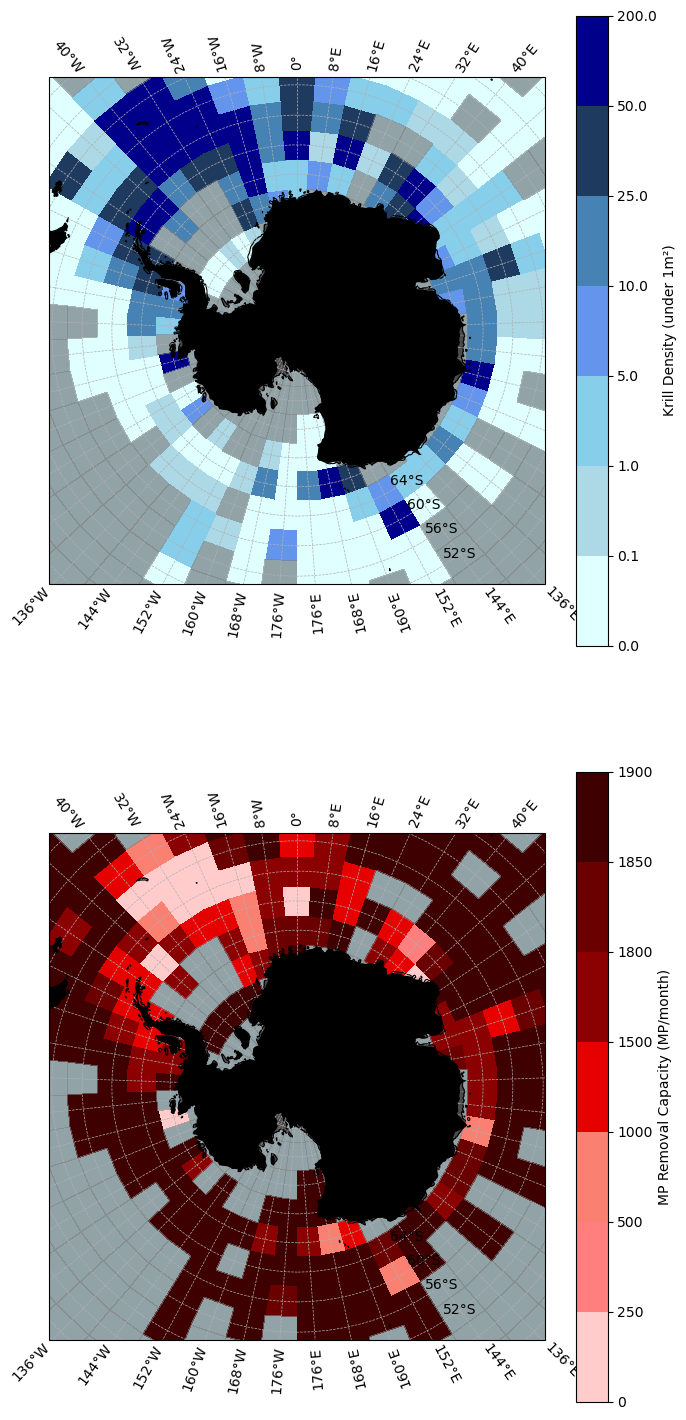

In [127]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Define the projection (South Polar Stereographic)
proj = ccrs.SouthPolarStereo()

# Create the figure and axis for two subplots (one for krill density, one for removal capacity)
fig, (ax1, ax2) = plt.subplots(figsize=(8, 18), nrows=2, subplot_kw={'projection': proj})

# Add land and ocean features to both axes
for ax in [ax1, ax2]:
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
    ax.add_feature(cfeature.LAND, color='black')
    ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())

# Add grid lines to both maps
for ax in [ax1, ax2]:
    gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)
    gl.xlocator = plt.MultipleLocator(8)  # Longitude grid lines every 8 degrees
    gl.ylocator = plt.MultipleLocator(4)  # Latitude grid lines every 4 degrees

# Initialize the krill grid
krill_grid = np.full((len(latitude_bins) - 1, len(longitude_bins) - 1), np.nan)

# Initialize the removal capacity grid (MP_removal_one_month)
removal_capacity_grid = np.full((len(latitude_bins) - 1, len(longitude_bins) - 1), np.nan)

# Map the number of krill and removal capacity to the grids
for _, row in krill_summary.iterrows():
    lat_min, lat_max = row['lat_bins'].left, row['lat_bins'].right
    lon_min, lon_max = row['long_bins'].left, row['long_bins'].right
    
    # Find the row and column indices for the grid
    lat_idx = np.digitize([lat_min], latitude_bins) - 1
    lon_idx = np.digitize([lon_min], longitude_bins) - 1
    
    # Assign the krill value to the corresponding grid cell
    krill_grid[lat_idx, lon_idx] = row['mean_standardised']
    
    # Assign the removal capacity value to the corresponding grid cell
    removal_capacity_grid[lat_idx, lon_idx] = row['conc_change_month']

# Define custom bin edges for both krill density and removal capacity
bin_edges = [0, 0.1, 1, 5, 10, 25, 50, 200]
removal_bin_edges = [   0.0, 250, 500,1000 ,1500 , 1800, 1850, 1900.0 ]
  # Adjust binning for removal capacity

# Define corresponding colors for the bins
bin_colors = [
    "#E0FFFF",  # 0 - 0.1
    "#ADD8E6",  # 0.1 - 1
    "#87CEEB",        # 1 - 5
    "#6495ED",         # 5 - 10
    "#4682B4",       # 10 - 25
    "#1E3A5F",       # 25 - 50
    "#00008B",          # 50 - 200
]

removal_bin_colors = [
    "#FFCCCB",  # 0 - 1
    "#FF7F7F",  # 1 - 5
    "#FA8072",       # 5 - 10
    "#E60000",      # 10 - 25
    "#8B0000",      # 25 - 50
    "#6A0000",         # 50 - 100
    "#3E0000",     # 100 - 500
]

# Create colormaps and norms for both grids
krill_cmap = ListedColormap(bin_colors)
krill_norm = BoundaryNorm(bin_edges, krill_cmap.N)

removal_cmap = ListedColormap(removal_bin_colors)
removal_norm = BoundaryNorm(removal_bin_edges, removal_cmap.N)

# Mask NaN values so they are displayed separately
masked_krill_grid = np.ma.masked_where(np.isnan(krill_grid), krill_grid)
masked_removal_grid = np.ma.masked_where(np.isnan(removal_capacity_grid), removal_capacity_grid)

# Plot krill grid
mesh_krill = ax1.pcolormesh(longitude_bins, latitude_bins, masked_krill_grid, cmap=krill_cmap, norm=krill_norm,
                            transform=ccrs.PlateCarree(), shading='flat')

# Plot removal capacity grid
mesh_removal = ax2.pcolormesh(longitude_bins, latitude_bins, masked_removal_grid, cmap=removal_cmap, norm=removal_norm,
                              transform=ccrs.PlateCarree(), shading='flat')

# Overlay NaN values manually in grey on both maps
nan_mask_krill = np.isnan(krill_grid)
nan_mask_removal = np.isnan(removal_capacity_grid)

ax1.pcolormesh(longitude_bins, latitude_bins, np.where(nan_mask_krill, 1, np.nan),
               cmap=ListedColormap(['grey']), transform=ccrs.PlateCarree(), shading='flat', alpha=0.6)

ax2.pcolormesh(longitude_bins, latitude_bins, np.where(nan_mask_removal, 1, np.nan),
               cmap=ListedColormap(['grey']), transform=ccrs.PlateCarree(), shading='flat', alpha=0.6)

# Add colorbars for both maps
cbar_krill = plt.colorbar(mesh_krill, ax=ax1, orientation='vertical', label='Krill Density (under 1m²)')
cbar_krill.set_ticks(bin_edges)

cbar_removal = plt.colorbar(mesh_removal, ax=ax2, orientation='vertical', label='MP Removal Capacity (MP/month)')
cbar_removal.set_ticks(removal_bin_edges)

# Overlay Antarctica with black on both maps
for ax in [ax1, ax2]:
    ax.add_feature(cfeature.NaturalEarthFeature(
        category='physical', name='land', scale='110m', facecolor='black'), zorder=10)

# Show the plot
plt.show()


# Itertools 

In [ ]:
#count function 

import itertools

counter = itertools.count(start=5, step=5) #counts from 0 up to infinity

print(next(counter)) #prints 0
print(next(counter)) #prints 1
print(next(counter)) #prints 2

data = [100, 200, 300, 400, 500]
#can use count function to provide values for any amount of data
daily_data = zip(itertools.count(), data) #returns an interator that combines the count and data
#can get a list by using list(daily_data)
print(list(daily_data))


#just getting one at a time 






5
10
15
[(0, 100), (1, 200), (2, 300), (3, 400), (4, 500)]


In [7]:
#zip_longest function

import itertools

data = [100, 200, 300, 400, 500]
daily_data = itertools.zip_longest(range(10), data)

print(list(daily_data))
#zip stops when the shortest iterable is exhausted
#zip_longest continues until the longest iterable is exhausted

[(0, 100), (1, 200), (2, 300), (3, 400), (4, 500), (5, None), (6, None), (7, None), (8, None), (9, None)]


In [9]:
#cycle function
#returns an iterable that will go forever
#can be used to cycle through a list

import itertools

counter = itertools.cycle([1, 2, 3])
print(next(counter)) #prints 1
print(next(counter)) #prints 2
print(next(counter)) #prints 3
print(next(counter)) #prints 1
print(next(counter)) #prints 2

1
2
3
1
2


In [ ]:
#repeat function
#returns an iterator that produces the same value each time it is called
#can be used to repeat a value a certain number of times
import itertools

counter = itertools.repeat(2, times=3)

squares = map(pow, range(10), itertools.repeat(2)) #map takes a functino and then it takes iterables and applies the function to each element of the iterable
print(list(squares)) 


# print(next(counter)) #prints 2
# print(next(counter)) #prints 2
# print(next(counter)) #prints 2
# print(next(counter)) #prints 2 #get an error here becuase it has been repeated 3 times
# print(next(counter)) #prints 2

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [4]:
#starmap function
#similar to map but the function takes arguments as a tuple
import itertools

squares = itertools.starmap(pow, [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)])
print(list(squares)) #prints [0, 1, 4, 9, 16]

[0, 1, 4, 9, 16]


In [5]:
#chain function

import itertools

letters = ['a', 'b', 'c', 'd']
numbers = [1, 2, 3, 4]
names = ['Corey', 'Nicole'] 

combined = itertools.chain(letters, numbers, names)

for item in combined:
    print(item)


a
b
c
d
1
2
3
4
Corey
Nicole


In [6]:
#islice function
#similar to slicing a list
import itertools

result = itertools.islice(range(10), 1, 5, 2) #start at 1, stop at 5, step by 2
for item in result:
    print(item)

1
3


# Tracking single FP

In [ ]:
##This does not have the most recent updates - breakage and MP size ones 16/2 and 17/2 updates from notion

import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens
)
import scipy.stats as stats
import netCDF4 as nc
import pandas as pd

# Parameters
krill_length_mm = 50  # mm
mp_conc = 500  # particles/m3
depth_limit = 2000  # m
time = np.linspace(0, 200, 1000)  # Simulation time in hours
b = -0.3  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of seawater 
gut_passage_time = 2  # Gut passage time in hours

##importing the temperature and salinity 
temp_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1M-m_1739443916403.nc')
sal_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-so_anfc_0.083deg_P1M-m_1739443856060.nc')
# Get the temperature variable (adjust the name if different in your file)
temp = temp_data.variables['thetao'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_t = temp_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_t = temp_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_t = temp_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_t = temp_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_temp = np.mean(temp, axis=(0, 2, 3))
temp_avg = pd.DataFrame({
    'Depth': depth_t,
    'Average Temperature': avg_temp})
temp_avg = temp_avg.dropna()


# Get the temperature variable (adjust the name if different in your file)
sal = sal_data.variables['so'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_s = sal_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_s = sal_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_s = sal_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_s = sal_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_sal = np.mean(sal, axis=(0, 2, 3))
sal_avg = pd.DataFrame({
    'Depth': depth_s,
    'Average Salinity': avg_sal})
sal_avg = sal_avg.dropna()


##merge the two data sets on the depth column 
temp_sal_data = pd.merge(temp_avg, sal_avg, how = 'inner')
temp_sal_data['Density'] = swdens(temp_sal_data['Average Temperature'], temp_sal_data['Average Salinity'])


# Compute ingestion and egestion rates
clearance_rate = calc_clearance_rate(krill_length_mm)
krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

# Fecal pellet release times
fp_release_times = np.arange(0, max(time), gut_passage_time)
mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)



# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Simulate sinking for each fecal pellet
for release_time in fp_release_times:
    pellet_time = time[time >= release_time]  # Time after release
    time_since_release = pellet_time - release_time  # Time elapsed since egestion

    # **Generate unique length, width, and density for each fecal pellet**
    L_init = generate_random(2927, 2667, 517, 34482) * 10**-6  # Initial FP length (m)
    D = generate_random(183, 178, 80, 600) * 10**-6  # Width/diameter of FP (m)
    rho_s = generate_random(1121, 1116, 1038, 1391)  # Density of krill FP

    # Compute initial sinking velocity for this pellet
    initial_sinking_velocity = calc_sinking_velocity(mu, rho, rho_s, L_init, D)

    # Initialize values
    current_depth = 100
    L = L_init
    ws = initial_sinking_velocity
    dt = (time[1] - time[0])  # Time step in hours
    sinking_depths = []
    
    # Store breakage points for visualization
    breakage_points = []  # List to store (time, depth) of breakage events

    # # Determine if this FP will break within the top 300m
    # will_break = np.random.rand() < 0.2  # 20% probability
    broke = False  # Track if breakage occurred

    for t in time_since_release:
        if current_depth >= depth_limit:
            break  # Stop tracking if pellet reaches the max depth
            
        # Update length based on depth
        delta_L = L_init - calc_length_decrease(L_init, b, current_depth)

        
            # Apply breakage if within top 300m
        if 110 <= current_depth <= 300 and np.random.rand() < 0.02 and not broke:
            #print(f"Before break: Length = {L:.6f}, Sinking velocity = {ws:.6f}")
            L = (L_init - delta_L) / 2  # Halve the length upon breakage
            broke = True 
            breakage_points.append((release_time + t, current_depth))
            #ws = calc_sinking_velocity(mu, rho_at_depth, rho_s, L, D)  # Recalculate ws
            #print(f"After break: Length = {L:.6f}, Sinking velocity = {ws:.6f}")

        else:
            L = L_init - delta_L
        
        #update the water density
        nearest_depth_index = (temp_sal_data['Depth'] - current_depth).abs().idxmin()
        rho_at_depth = temp_sal_data.loc[nearest_depth_index, 'Density'] *1000

        # Recalculate sinking velocity with updated length
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s, L, D) 
        ws_per_hour = ws / 24  # Convert m/day to m/hour
        
        # Update depth
        current_depth += ws_per_hour * dt
        sinking_depths.append(current_depth)
        
        # Plot breakage points
    if breakage_points:
        break_times, break_depths = zip(*breakage_points)  # Extract times and depths
        ax.scatter(break_times, break_depths, color='black', marker='x', label="Breakage Event", s=50)

    # Stop at max depth
    sinking_depths = np.clip(sinking_depths, 0, depth_limit)

    # Determine if this FP contains microplastics
    contains_mp = np.any(np.isclose(release_time, mp_fp_release_times, atol=gut_passage_time / 2))
    color = "red" if contains_mp else "blue"

    ax.plot(pellet_time[:len(sinking_depths)], sinking_depths, color=color)

# Formatting
ax.invert_yaxis()  # Invert y-axis to show depth increasing downward
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
#ax.set_title(f"Sinking Fecal Pellets with Stopping Condition at 40% Mass Loss")
ax.grid()

# Add legend
ax.plot([], [], color='red', label='Contains Microplastics')
ax.plot([], [], color='blue', label='No Microplastics')
#ax.legend()

# Show plot
plt.show()

In [33]:
#Without breaking 

#%% microplastics rising again with breaking

import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_length_decrease,
    generate_random,
    calc_rising_velocity,
    assign_mp_size
)
import pandas as pd
from scipy.interpolate import interp1d

# Parameters (unchanged)
krill_length_mm = 50
depth_limit = 2000
time = np.linspace(0, 500, 10000)
b = -0.32
mu = 0.001
rho = 1025
gut_passage_time = 5
mp_conc = 1900
rho_p = 960


# Compute ingestion/egestion rates (unchanged)
clearance_rate = calc_clearance_rate(krill_length_mm)
krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

# Fecal pellet release times (unchanged)
fp_release_times = np.arange(0, max(time), gut_passage_time)
mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

# Load density data and interpolate (unchanged)
rho_data = pd.read_csv('C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv')
rho_interp = interp1d(rho_data['Depth'], rho_data['Density'] * 1000, kind='linear', fill_value="extrapolate")

# Precompute pellet properties (unchanged)
num_pellets = len(fp_release_times)
L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
rho_s = rho_s = np.full(num_pellets, 1050)
mp_size = assign_mp_size(size=num_pellets)

# Identify MP-containing pellets
tolerance = gut_passage_time / 2
is_mp_pellet = np.zeros(num_pellets, dtype=bool)


for i in range(num_pellets):
    # Check if release time matches MP pellet release times
    time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
    # Check if MP size is smaller than pellet diameter
    size_condition = (mp_size[i] < D[i])
    is_mp_pellet[i] = time_match and size_condition

# Initialize storage for depth-time data
mp_depth_over_time = []

# Simulate sinking for MP-containing pellets
for i in np.where(is_mp_pellet)[0]:
    release_time = fp_release_times[i]
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time
    
    current_depth = 100
    ws = calc_sinking_velocity(mu, rho_interp(current_depth), rho_s[i], L_init[i], D[i])
    dt = time[1] - time[0]
    
    
    for t in time_since_release:
        if current_depth >= depth_limit:
            break  # Stop if sunk or MP released
        
        # Update length based on depth
        delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
        
        global_time = release_time + t
        
        
        # Calculate density and sinking velocity
        rho_at_depth = rho_interp(current_depth)
        L = L_init[i] - delta_L 
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
        ws_per_hour = ws / 24
        current_depth += ws_per_hour * dt
        
        # Record depth and time
    
        mp_depth_over_time.append((i, global_time, current_depth))

    
# Initialize storage for depth-time data for non-MP pellets
non_mp_depth_over_time = []

# Simulate sinking for non-MP-containing pellets
for i in np.where(~is_mp_pellet)[0]:
    release_time = fp_release_times[i]
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time
    
    current_depth = 100
    dt = time[1] - time[0]
    broke = False
    
    for t in time_since_release:
        if current_depth >= depth_limit:
            break  # Stop if reached depth limit
        
        # Update pellet length change due to sinking
        delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
        global_time = release_time + t
        
        # Calculate density and sinking velocity for the pellet
        rho_at_depth = rho_interp(current_depth)
        # Use half the length change after breakage if broke, otherwise full value
        L = L_init[i] - delta_L 
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
        ws_per_hour = ws / 24
        current_depth += ws_per_hour * dt
        
        non_mp_depth_over_time.append((i, global_time, current_depth))


        

# Convert to DataFrame for analysis
import pandas as pd
df_fp = pd.DataFrame(mp_depth_over_time, columns=['Pellet ID','Time (hours)', 'Depth (m)'])
df_non_mp = pd.DataFrame(non_mp_depth_over_time, columns=['Pellet ID','Time (hours)', 'Depth (m)'])

In [34]:
print(df_fp)

       Pellet ID  Time (hours)   Depth (m)
0              5     25.002500  101.377302
1              5     25.052505  102.752347
2              5     25.102510  104.125168
3              5     25.152515  105.495799
4              5     25.202520  106.864272
...          ...           ...         ...
64424         96    499.799980  146.560847
64425         96    499.849985  146.675902
64426         96    499.899990  146.790947
64427         96    499.949995  146.905981
64428         96    500.000000  147.021004

[64429 rows x 3 columns]


In [35]:
#%% microplastics rising again with breaking

import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_length_decrease,
    generate_random,
    calc_rising_velocity,
    assign_mp_size
)
import pandas as pd
from scipy.interpolate import interp1d

# Parameters (unchanged)
krill_length_mm = 50
depth_limit = 2000
time = np.linspace(0, 500, 10000)
b = -0.32
mu = 0.001
rho = 1025
gut_passage_time = 4
mass_loss_threshold = 0.4
mp_conc = 1900
rho_p = 960
mp_release_depths = []
mp_release_events = []

# Compute ingestion/egestion rates (unchanged)
clearance_rate = calc_clearance_rate(krill_length_mm)
krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

# Fecal pellet release times (unchanged)
fp_release_times = np.arange(0, max(time), gut_passage_time)
mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

# Load density data and interpolate (unchanged)
rho_data = pd.read_csv('C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv')
rho_interp = interp1d(rho_data['Depth'], rho_data['Density'] * 1000, kind='linear', fill_value="extrapolate")

# Precompute pellet properties (unchanged)
num_pellets = len(fp_release_times)
L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
rho_s = rho_s = np.full(num_pellets, 1050)
mp_size = assign_mp_size(size=num_pellets)
break_depths = np.random.uniform(100, 300, size=num_pellets)
break_chances = np.random.rand(num_pellets) < 0.63

# Identify MP-containing pellets
tolerance = gut_passage_time / 2
is_mp_pellet = np.zeros(num_pellets, dtype=bool)


for i in range(num_pellets):
    # Check if release time matches MP pellet release times
    time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
    # Check if MP size is smaller than pellet diameter
    size_condition = (mp_size[i] < D[i])
    is_mp_pellet[i] = time_match and size_condition

# Initialize storage for depth-time data
mp_depth_over_time = []

# Simulate sinking for MP-containing pellets
for i in np.where(is_mp_pellet)[0]:
    release_time = fp_release_times[i]
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time
    
    current_depth = 100
    ws = calc_sinking_velocity(mu, rho_interp(current_depth), rho_s[i], L_init[i], D[i])
    dt = time[1] - time[0]
    broke = False
    mp_released = False
    
    for t in time_since_release:
        if current_depth >= depth_limit or mp_released:
            break  # Stop if sunk or MP released
        
        # Update length based on depth
        delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
        
        global_time = release_time + t
        
        # Apply breakage if within top 300m
        if current_depth >= break_depths[i] and break_chances[i] and not broke:
            broke = True
            if mp_size[i] > 0.5 * D[i]:
                mp_released = True  # MP released, stop tracking
                global_time = release_time + t
                mp_release_events.append((global_time, current_depth, mp_size[i]))
                break
        
        # Calculate density and sinking velocity
        rho_at_depth = rho_interp(current_depth)
        L = L_init[i] - delta_L if not broke else (L_init[i] - delta_L) / 2
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
        ws_per_hour = ws / 24
        current_depth += ws_per_hour * dt
        
        # Record depth and time
    
        mp_depth_over_time.append((i, global_time, current_depth))

    
# Initialize storage for depth-time data for non-MP pellets
non_mp_depth_over_time = []

# Simulate sinking for non-MP-containing pellets
for i in np.where(~is_mp_pellet)[0]:
    release_time = fp_release_times[i]
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time
    
    current_depth = 100
    dt = time[1] - time[0]
    broke = False
    
    for t in time_since_release:
        if current_depth >= depth_limit:
            break  # Stop if reached depth limit
        
        # Update pellet length change due to sinking
        delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
        global_time = release_time + t
        
        # Apply breakage if within top 300m (simulate breakage without releasing MP)
        if current_depth >= break_depths[i] and break_chances[i] and not broke:
            broke = True
        
        # Calculate density and sinking velocity for the pellet
        rho_at_depth = rho_interp(current_depth)
        # Use half the length change after breakage if broke, otherwise full value
        L = L_init[i] - delta_L if not broke else (L_init[i] - delta_L) / 2
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
        ws_per_hour = ws / 24
        current_depth += ws_per_hour * dt
        
        non_mp_depth_over_time.append((i, global_time, current_depth))


        

mp_rising_trajectories = []

for event in mp_release_events:
    release_time, release_depth, size = event
    velocity = calc_rising_velocity(size, rho_p, rho, mu)  # m/day
    velocity_hour = velocity / 24  # Convert to m/hour
    
    # Get times after release
    post_release_times = time[time >= release_time]
    
    for t in post_release_times:
        elapsed_hours = t - release_time
        new_depth = release_depth - velocity_hour * elapsed_hours
        if new_depth <= 0:
            new_depth = 0
            break  # Stop tracking after surfacing
        mp_rising_trajectories.append((event, t, new_depth))

# Convert to DataFrame for analysis
import pandas as pd
df_fp_break = pd.DataFrame(mp_depth_over_time, columns=['Pellet ID','Time (hours)', 'Depth (m)'])
df_mp_break = pd.DataFrame(mp_release_events, columns=['Time (hours)', 'Depth (m)', 'Size (um)'])
df_rising_break = pd.DataFrame(mp_rising_trajectories, columns=['MP ID','Time (hours)', 'Depth (m)'])
df_non_mp_break = pd.DataFrame(non_mp_depth_over_time, columns=['Pellet ID','Time (hours)', 'Depth (m)'])




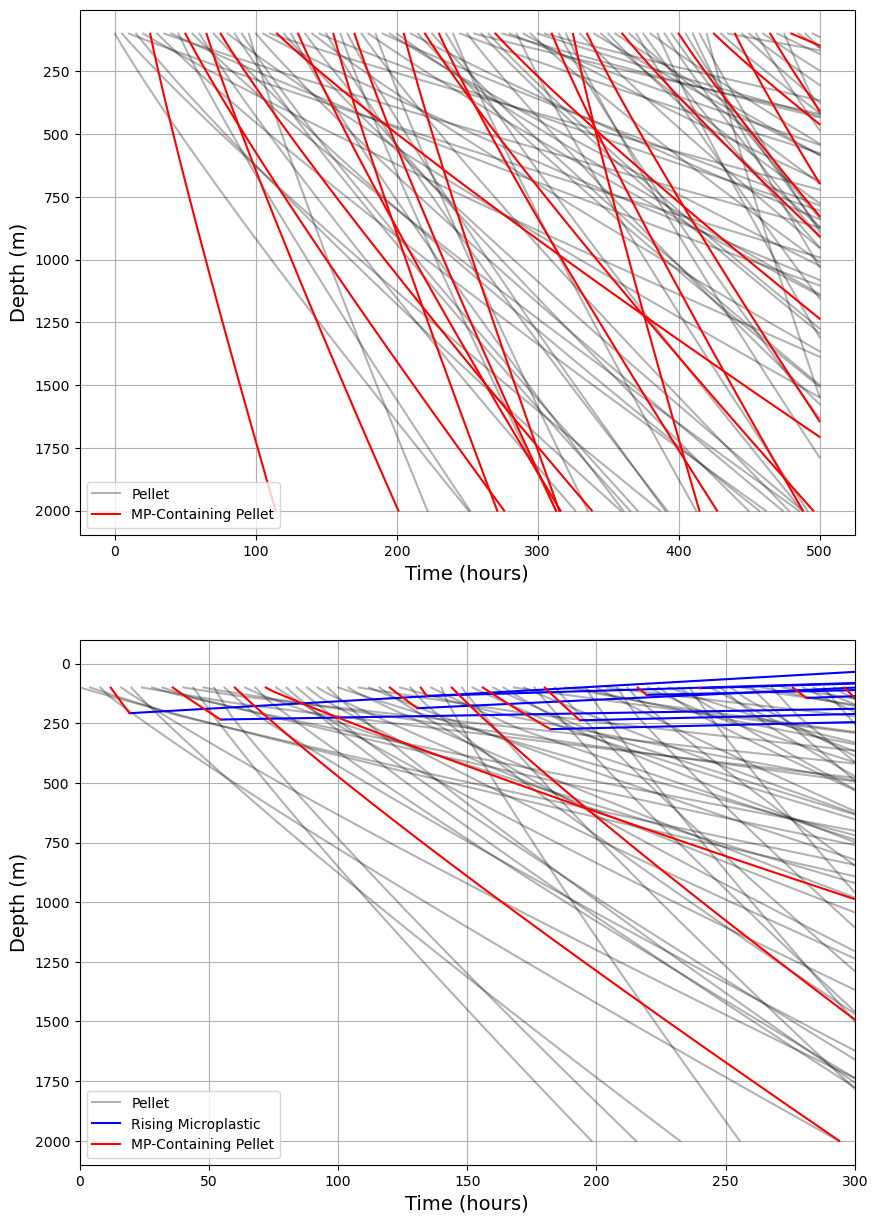

In [36]:
# Plot results

fig, ax = plt.subplots(2,1, figsize=(10, 15))

for pid, group in df_non_mp.groupby('Pellet ID'):
    ax[0].plot(group['Time (hours)'], group['Depth (m)'], alpha=0.3, c='black', label='Pellet' if pid == df_non_mp['Pellet ID'].unique()[0] else "")

for pid, group in df_fp.groupby('Pellet ID'):
    ax[0].plot(group['Time (hours)'], group['Depth (m)'], alpha=1, c='red', label='MP-Containing Pellet' if pid == df_fp['Pellet ID'].unique()[0] else "")



ax[0].invert_yaxis()  # Depth increases downward
ax[0].set_xlabel('Time (hours)', fontsize= 14)
ax[0].set_ylabel('Depth (m)', fontsize= 14)
#ax[0].set_xlim(0, 300)
ax[0].grid()
ax[0].legend()


for pid, group in df_non_mp_break.groupby('Pellet ID'):
    ax[1].plot(group['Time (hours)'], group['Depth (m)'], alpha=0.3, c='black', label='Pellet' if pid == df_non_mp_break['Pellet ID'].unique()[0] else "")

for pid, group in df_rising_break.groupby('MP ID'):
    ax[1].plot(group['Time (hours)'], group['Depth (m)'], alpha=1,zorder = 3, c='blue', label='Rising Microplastic' if pid == df_rising_break['MP ID'].unique()[0] else "")

for pid, group in df_fp_break.groupby('Pellet ID'):
    ax[1].plot(group['Time (hours)'], group['Depth (m)'], alpha=1, zorder = 3, c='red', label='MP-Containing Pellet' if pid == df_fp_break['Pellet ID'].unique()[0] else "")

ax[1].invert_yaxis()  # Depth increases downward
ax[1].set_xlabel('Time (hours)', fontsize= 14)
ax[1].set_ylabel('Depth (m)', fontsize= 14)
ax[1].set_xlim(0, 300)
ax[1].grid()
ax[1].legend()


# Flux plots

0.5276943714472221
0.3712817995427717


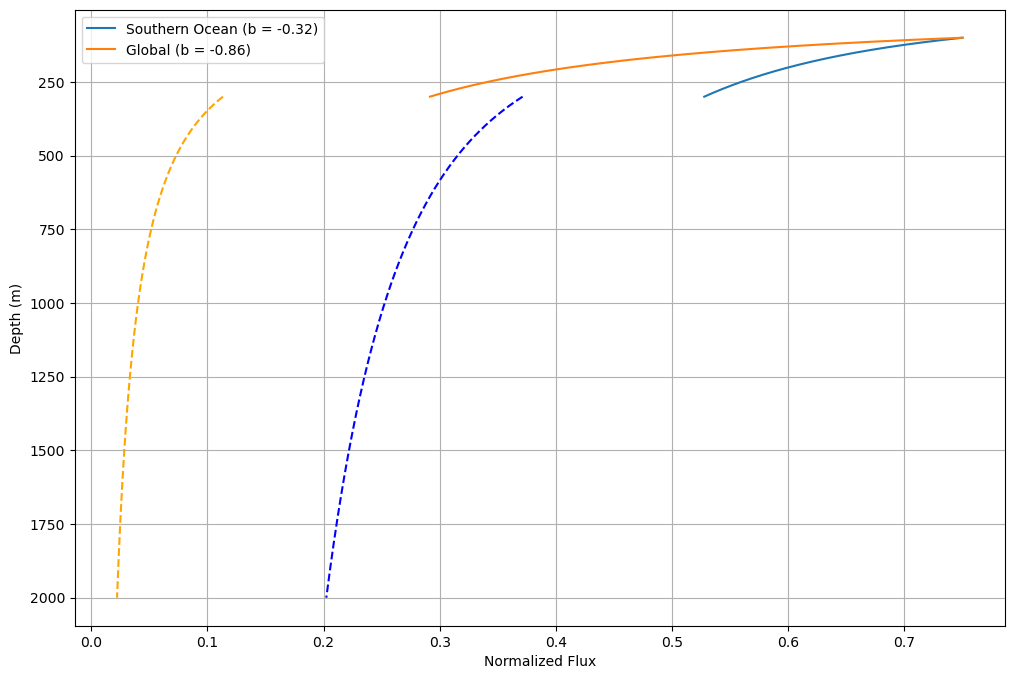

In [18]:
#martin attenuation curve with 0.3 (southern ocean) and 0.86 (global)
#but this is for length and not for flux of microplastics


import numpy as np
import matplotlib.pyplot as plt

# Parameters
b_southern_ocean = - 0.32
b_global = - 0.86
depth_shallow = np.linspace(100, 300, 1000)
depth_deep = np.linspace(300, 2000, 1000)
L_init = 1 # Initial length (normalized)
L_so_shal = L_init  * (depth_shallow / 100) ** b_southern_ocean * (3/4)
L_global_shal = L_init  * (depth_shallow / 100) ** b_global * (3/4)

L_so_deep = L_so_shal[-1]  * (depth_deep / 100) ** b_southern_ocean 
L_global_deep = L_global_shal[-1] * L_init  * (depth_deep / 100) ** b_global

#add in the breaking function as well
for i, d in enumerate(depth):
    if d < 300:  
        L_so[i] *= 3/4  
        L_global[i] *= 3/4  

print(L_so_shal[-1])
print(L_so_deep[0])

# Plot results
plt.figure(figsize=(12, 8))
plt.gca().invert_yaxis()
plt.plot(L_so_shal, depth_shallow, label=f"Southern Ocean (b = {b_southern_ocean})")
plt.plot(L_global_shal, depth_shallow, label=f"Global (b = {b_global})")
plt.plot(L_so_deep, depth_deep, linestyle='--', color='blue')
plt.plot(L_global_deep, depth_deep, linestyle='--', color='orange')
plt.xlabel("Normalized Flux")
plt.ylabel("Depth (m)")
#plt.title("Martin Attenuation Curve for Southern Ocean and Global")
plt.grid()
plt.legend()
plt.show()


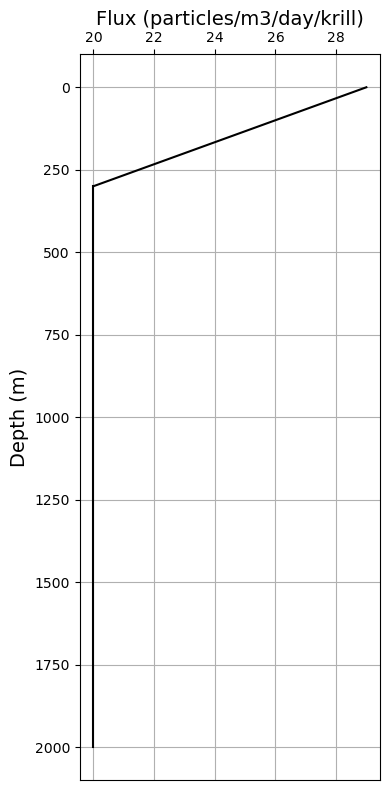

In [99]:
import numpy as np
import matplotlib.pyplot as plt

# parameters
depth_shallow = np.linspace(0, 300, 1000)  # Depth in meters
flux_shallow = 29 - ((29-20)/300) * depth_shallow  

depth_deep = np.linspace(300, 2000, 1000)  # Depth in meters
flux_deep = np.full(len(depth_deep), 20)  # Constant flux below 300m


# plotting
plt.figure(figsize=(4, 8))
ax = plt.gca()
ax.invert_yaxis()  # Invert y-axis for depth
ax.plot(flux_shallow, depth_shallow, label="Flux (0-300m)", color='black')
ax.plot(flux_deep, depth_deep, label="Flux (300-2000m)", color='black')

# Set x-axis labels and ticks at the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Flux (particles/m3/day/krill)", fontsize=14)

# Y-axis label and grid
ax.set_ylabel("Depth (m)", fontsize=14)
ax.grid()

plt.tight_layout()
plt.show()


# Data analysis

## Density data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens,
    assign_mp_size
)
import netCDF4 as nc
import pandas as pd

##importing the temperature and salinity 
temp_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1M-m_1739443916403.nc')
sal_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-so_anfc_0.083deg_P1M-m_1739443856060.nc')
# Get the temperature variable (adjust the name if different in your file)
temp = temp_data.variables['thetao'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_t = temp_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_t = temp_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_t = temp_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_t = temp_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_temp = np.mean(temp, axis=(0, 2, 3))
temp_avg = pd.DataFrame({
    'Depth': depth_t,
    'Average Temperature': avg_temp})
temp_avg = temp_avg.dropna()


# Get the temperature variable (adjust the name if different in your file)
sal = sal_data.variables['so'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_s = sal_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_s = sal_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_s = sal_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_s = sal_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_sal = np.mean(sal, axis=(0, 2, 3))
sal_avg = pd.DataFrame({
    'Depth': depth_s,
    'Average Salinity': avg_sal})
sal_avg = sal_avg.dropna()


##merge the two data sets on the depth column 
temp_sal_data = pd.merge(temp_avg, sal_avg, how = 'inner')
temp_sal_data['Density'] = swdens(temp_sal_data['Average Temperature'], temp_sal_data['Average Salinity'])
rho_data = temp_sal_data

# Save density dataset separately
rho_data_path = 'C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv'
rho_data.to_csv(rho_data_path, index=False)

Text(0, 0.5, 'Depth (m)')

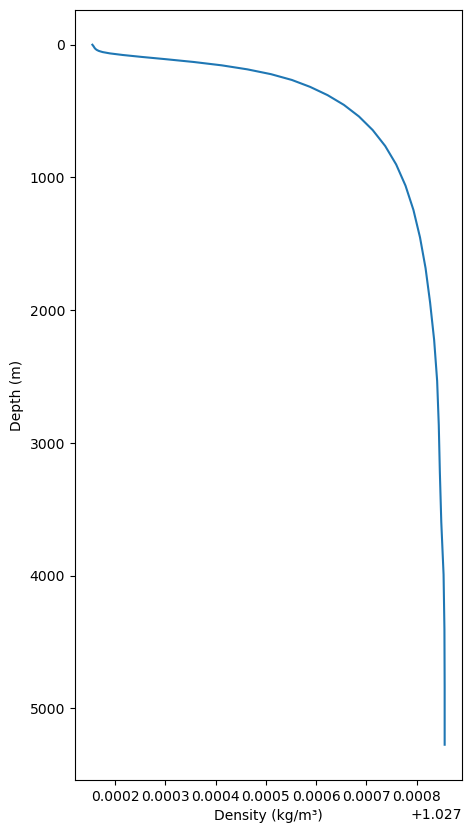

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
rho_data = pd.read_csv('rho_data.csv')
rho_data

fig, ax = plt.subplots(figsize=(5, 10))
ax.plot(rho_data['Density'], rho_data['Depth'])
ax.invert_yaxis()  # Invert y-axis to show depth increasing downward
ax.set_xlabel('Density (kg/m³)')
ax.set_ylabel('Depth (m)')

## FP lengths

Ratio of values below 0.5 to above 0.5: 0.2111801242236025


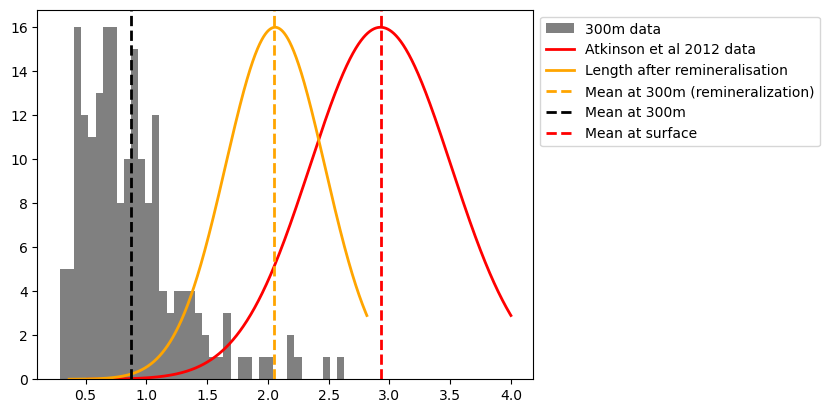

In [12]:
#%% analysing the FP_length data 

import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import numpy as np
from onekrill_onecolumn import calc_length_decrease

FP_length = pd.read_csv('FP_length.csv')

def truncated_normal_pdf(mean, min_val, max_val, num_points=1000):
    """
    Computes x-values and corresponding PDF values for a truncated normal distribution.

    Parameters:
        mean (float): Mean of the distribution.
        min_val (float): Minimum possible value.
        max_val (float): Maximum possible value.
        num_points (int): Number of points for smooth curve.

    Returns:
        x (numpy array): Range of values from min_val to max_val.
        pdf_y (numpy array): PDF values corresponding to x.
    """
    # Estimate standard deviation
    std_dev = (max_val - min_val) / 6  # Rough estimate assuming normal-like distribution

    # Define bounds in standard normal form
    lower_bound = (min_val - mean) / std_dev
    upper_bound = (max_val - mean) / std_dev

    # Create truncated normal distribution
    distribution = stats.truncnorm(lower_bound, upper_bound, loc=mean, scale=std_dev)

    # Generate x values (range for PDF calculation)
    x = np.linspace(min_val, max_val, num_points)

    # Compute the probability density function (PDF)
    pdf_y = distribution.pdf(x)

    return x, pdf_y  # Return values for plotting

x, pdf_y = truncated_normal_pdf(2.927, 0.517, 4.0, num_points=1000)
pdf_y_scaled = pdf_y * 16 / max(pdf_y)  # Normalize PDF to histogram

x_remin = calc_length_decrease(x, -0.32, 300)
mean_remin = calc_length_decrease(2.927, -0.3, 300)

mean_length = FP_length['Length '].mean()

plt.hist(FP_length['Length '], bins = 40, label='300m data', color = 'grey')
plt.plot(x, pdf_y_scaled, color='red', linewidth=2, label="Atkinson et al 2012 data")
plt.plot(x_remin, pdf_y_scaled, color = 'orange', linewidth=2, label= "Length after remineralisation")
plt.axvline(x=2.05, color='orange', linestyle='--', linewidth=2, label = "Mean at 300m (remineralization)")
plt.axvline(x=mean_length, color='black', linestyle='--', linewidth=2, label="Mean at 300m")
plt.axvline(x=2.927, color='red', linestyle='--', linewidth=2, label="Mean at surface")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

#save as a png file
plt.savefig('C:/Users/elican27/Documents/Antarctic_krill/Model/Figures/FP_length_analysis.png', dpi=300, bbox_inches='tight')

#proportion of FP below 0.5mm 
below_count = (FP_length['Length '] < 0.5).sum()
above_count = (FP_length['Length ']  > 0.5).sum()

# Calculate the ratio
ratio = below_count / above_count if above_count > 0 else float('inf')

# Print the result
print(f"Ratio of values below 0.5 to above 0.5: {ratio}") 

In [24]:
import numpy as np
from scipy.integrate import simpson

FP_length = pd.read_csv('FP_length.csv')

# Compute histogram data
hist_vals, bin_edges = np.histogram(FP_length['Length '], bins=40, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Convert bin edges to centers

# Compute orange curve values at bin centers
orange_pdf_y = np.interp(bin_centers, x_remin, pdf_y_scaled)

# Compute area where histogram is below the orange curve
overlap = np.minimum(hist_vals, orange_pdf_y)  # Take minimum at each bin
total_overlap = simpson(overlap, bin_centers)  # Integrate to get total probability mass

# Compute the total histogram area
total_hist_area = simpson(hist_vals, bin_centers)

# Fraction of histogram under the orange curve
fraction_under_orange = total_overlap / total_hist_area

print(f"Fraction of histogram under the orange curve: {fraction_under_orange:.2f}")


Fraction of histogram under the orange curve: 0.37


## Microplastic data

Index(['Cruise', 'Sampling Date [dd/mm/yyyy]', 'Sampling Time [hh:mm:ss]',
       'Latitude [degrees_north]', 'Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sample ID ', 'Depth (m)', 'Volume sampled (L)',
       'Volume analysed (L)', 'IR Image Marker ID', 'IR Marker area (mm2)',
       'Number of particles - Polyethylene (N)',
       'Number of particles - Polypropylene (N)',
       'Number of particles - Polystyrene (N)', 'Remark'],
      dtype='object')
1909.6487628872694


C:\Users\elican27\AppData\Local\Temp\ipykernel_4456\4033546807.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dimension_data_PE[columns_to_fill_dimension_PE] = dimension_data_PE[columns_to_fill_dimension_PE].fillna(method="ffill")
C:\Users\elican27\AppData\Local\Temp\ipykernel_4456\4033546807.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dimension_data_PP[columns_to_fill_dimension_PP] = dimension_data_PP[columns_to_fill_dimension_PP].fillna(method="ffill")
C:\Users\elican27\AppData\Local\Temp\ipykernel_4456\4033546807.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dimension_data_PS[columns_to_fill_dimension_PS] = dimension_data_PE[columns_to_fill_dimension_PS].fillna(method="ffill")
C:\Users\elic

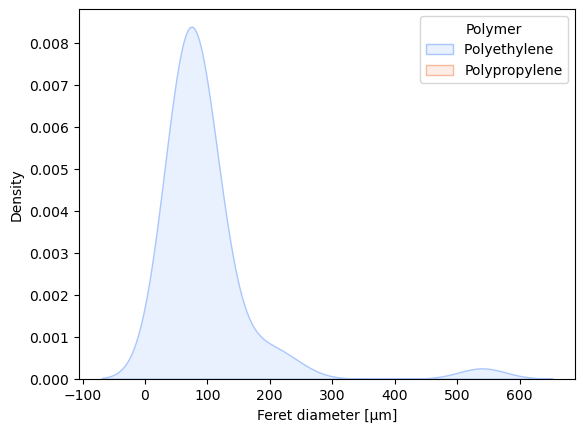

43.63


In [2]:
#%% Analysing the microplastics data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#importing the size and concentration data set and merge them on lat or long?
dimension_data_PE = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PE")
dimension_data_PP = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PP")
dimension_data_PS = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PS")
conc_data = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_counts-v17072020.xlsx")

columns_to_fill_dimension_PE = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_dimension_PP = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_dimension_PS = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_conc = ['Cruise', 'Sampling Date [dd/mm/yyyy]', 'Sampling Time [hh:mm:ss]',
       'Latitude [degrees_north]', 'Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sample ID ', 'Depth (m)', 'Volume sampled (L)']

dimension_data_PE[columns_to_fill_dimension_PE] = dimension_data_PE[columns_to_fill_dimension_PE].fillna(method="ffill")
dimension_data_PP[columns_to_fill_dimension_PP] = dimension_data_PP[columns_to_fill_dimension_PP].fillna(method="ffill")
dimension_data_PS[columns_to_fill_dimension_PS] = dimension_data_PE[columns_to_fill_dimension_PS].fillna(method="ffill")
conc_data[columns_to_fill_conc] = conc_data[columns_to_fill_conc].fillna(method="ffill")

conc_data['Depth (m)'] = conc_data['Depth (m)'].astype(int)

conc_data_so = conc_data[(conc_data['Latitude [degrees_north]'] <-40) &(conc_data['Depth (m)'] == 10)]
print(conc_data_so.columns)


#Working out the average microplastic concentration 
conc_data_so['Total_MP'] = conc_data_so['Number of particles - Polyethylene (N)']  + conc_data_so['Number of particles - Polypropylene (N)'] + conc_data_so['Number of particles - Polystyrene (N)']
conc_data_so['Conc (particles/m3)'] = (conc_data_so['Total_MP']/ conc_data_so['Volume analysed (L)']) * 1000

#print(conc_data_so['Conc (particles/m3)'])

avg_conc = conc_data_so['Conc (particles/m3)'].mean()

print(avg_conc)

#size distribution for all of the different plastic types - do I just clump then together?

dimension_data_PE['Sampling Depth [m]'] = dimension_data_PE['Sampling Depth [m]'].astype(int)
dimension_data_PP['Sampling Depth [m]'] = dimension_data_PP['Sampling Depth [m]'].astype(int)
dimension_data_PS['Sampling Depth [m]'] = dimension_data_PS['Sampling Depth [m]'].astype(int)

dimension_data_PS['Sampling position_Latitude [degrees_north]'] = pd.to_numeric(
    dimension_data_PS['Sampling position_Latitude [degrees_north]'], errors='coerce')
dimension_data_PS['Sampling Depth [m]'] = pd.to_numeric(
    dimension_data_PS['Sampling Depth [m]'], errors='coerce')

dimension_data_PE_so = dimension_data_PE[(dimension_data_PE['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PE['Sampling Depth [m]'] == 10)]
dimension_data_PP_so = dimension_data_PP[(dimension_data_PP['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PP['Sampling Depth [m]'] == 10)]
#dimension_data_PS_so = dimension_data_PS[(dimension_data_PS['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PS['Sampling Depth [m]'] == 10)]
#There is no PS data from around South Georgia!!!

dimension_data_so = pd.concat([dimension_data_PE_so, dimension_data_PP_so], ignore_index=True)
#print(dimension_data_so.columns)


sns.kdeplot(data = dimension_data_so, x='Feret diameter [µm]',hue = 'Polymer' ,fill=True, common_norm=False, palette='coolwarm')
##There is only one PP data point in the around South Georgia in the mixed layer 
#Thats why the plot only looks like it has one polymer type 
plt.show()

print(dimension_data_so['Feret diameter [µm]'].min())


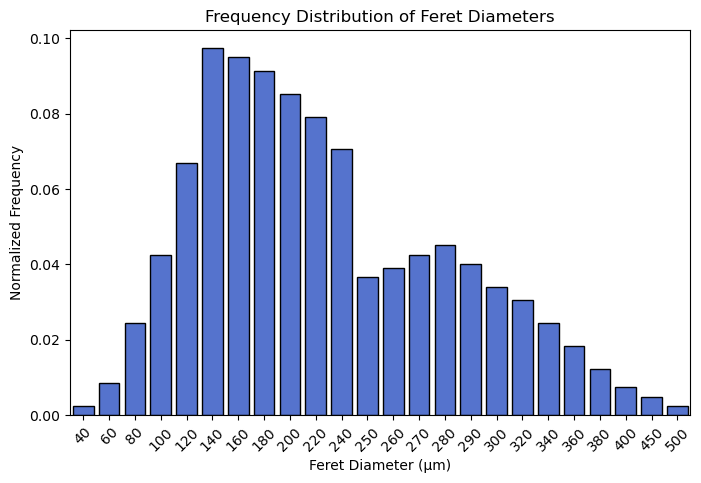

In [ ]:
# frequnecy distribution from Nan's data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
feret_diameters = [
    40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 270,
    280, 290, 300, 320, 340, 360, 380, 400, 450, 500
]

normalized_frequencies = np.array([
    0.00243309, 0.00851582, 0.02433090, 0.04257908, 0.06690998,
    0.09732360, 0.09489051, 0.09124088, 0.08515815, 0.07907543,
    0.07055961, 0.03649635, 0.03892944, 0.04257908, 0.04501217,
    0.04014599, 0.03406326, 0.03041363, 0.02433090, 0.01824818,
    0.01216545, 0.00729927, 0.00486618, 0.00243309
])

# Normalize frequencies (just in case)
normalized_frequencies /= normalized_frequencies.sum()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feret_diameters, y=normalized_frequencies, color='royalblue', edgecolor='black')

# Labels and title
plt.xlabel("Feret Diameter (µm)")
plt.ylabel("Normalized Frequency")
#plt.title("Frequency Distribution of Feret Diameters")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

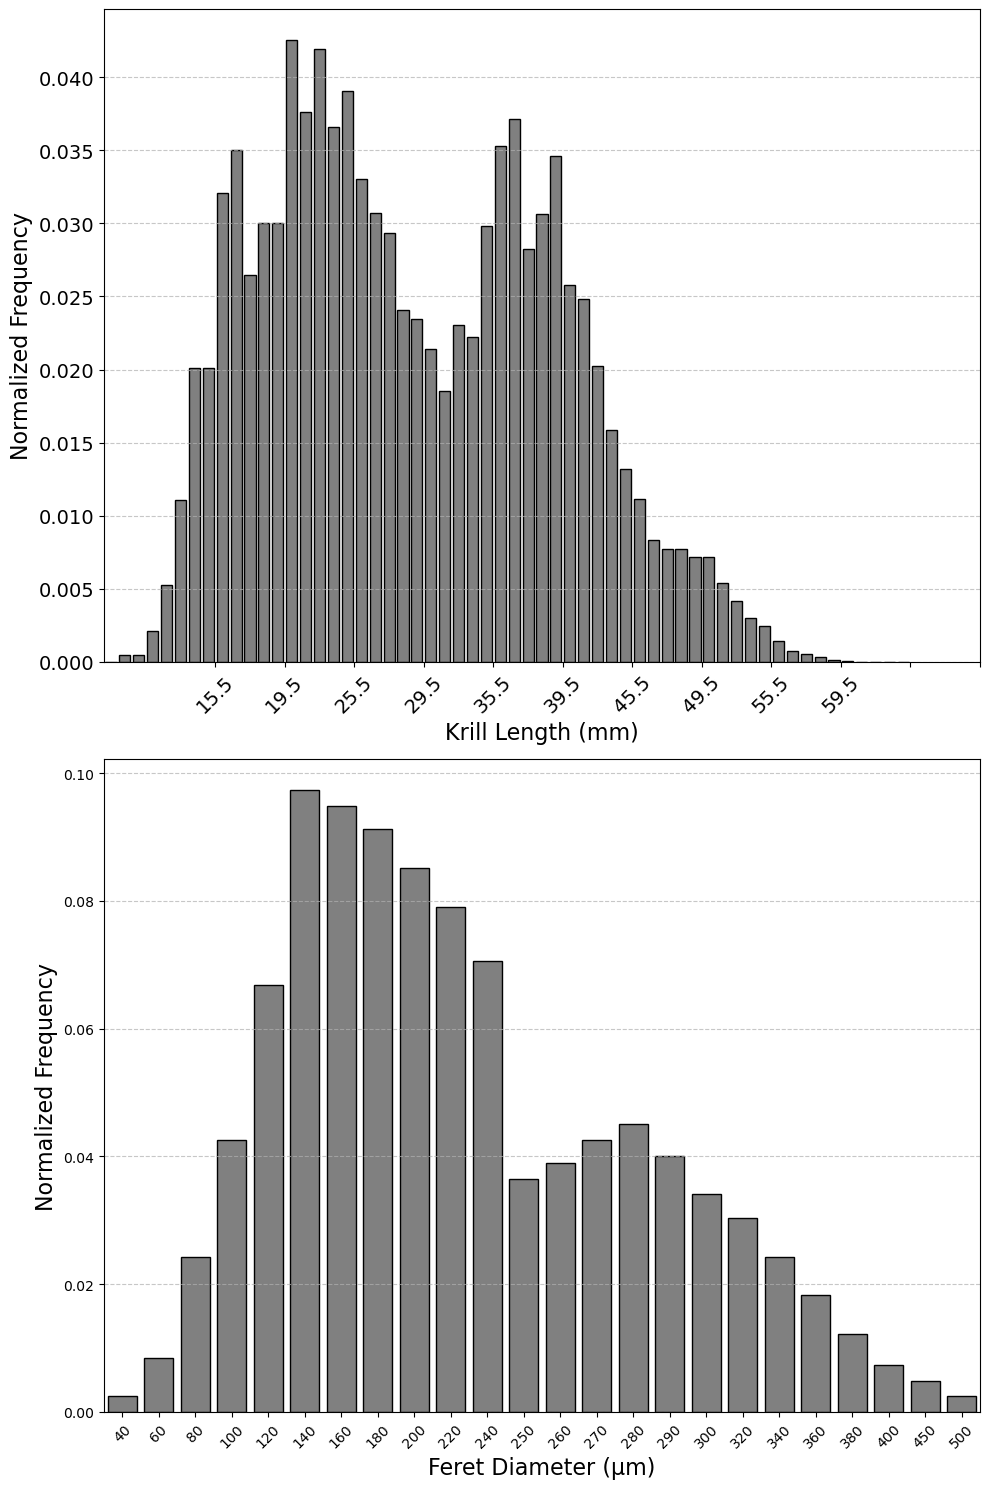

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load krill length data
krill_length = pd.read_csv("krill_length_data_datazoo.csv")

# Extract frequency values
frequencies = krill_length.iloc[-1, 8:-1].values
frequencies = pd.to_numeric(frequencies)  # Convert to numeric

# Define corresponding lengths
lengths = np.arange(7.5, 65, 1)

# Normalize frequencies
normalized_frequencies = frequencies / frequencies.sum()

# Create cleaned DataFrame
krill_length_clean = pd.DataFrame({
    'length': lengths,
    'normalized_frequency': normalized_frequencies
})

# Data for feret diameters
feret_diameters = [
    40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 270,
    280, 290, 300, 320, 340, 360, 380, 400, 450, 500
]

normalized_frequencies_feret = np.array([
    0.00243309, 0.00851582, 0.02433090, 0.04257908, 0.06690998,
    0.09732360, 0.09489051, 0.09124088, 0.08515815, 0.07907543,
    0.07055961, 0.03649635, 0.03892944, 0.04257908, 0.04501217,
    0.04014599, 0.03406326, 0.03041363, 0.02433090, 0.01824818,
    0.01216545, 0.00729927, 0.00486618, 0.00243309
])

# Normalize frequencies (just in case)
normalized_frequencies_feret /= normalized_frequencies_feret.sum()

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 15), sharex=False)

# Plot krill length distribution
sns.barplot(ax=axes[0], data=krill_length_clean, x='length', y='normalized_frequency', 
            color='grey', edgecolor='black')
axes[0].set_xlabel('Krill Length (mm)', fontsize=16)
axes[0].set_ylabel('Normalized Frequency', fontsize=16)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].set_xticks(lengths[::5])  # Reduce number of ticks
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot feret diameter distribution
sns.barplot(ax=axes[1], x=feret_diameters, y=normalized_frequencies_feret, 
            color='grey', edgecolor='black')
axes[1].set_xlabel("Feret Diameter (µm)", fontsize=16)
axes[1].set_ylabel("Normalized Frequency", fontsize=16)
axes[1].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='both', labelsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better visibility
plt.tight_layout()

# Show plot
plt.show()

#save figure 
fig.savefig('C:/Users/elican27/Documents/Antarctic_krill/Model/Figures/krill_and_plastic_distribution.png',dpi = 300, bbox_inches='tight')

## Krill lengths and numbers

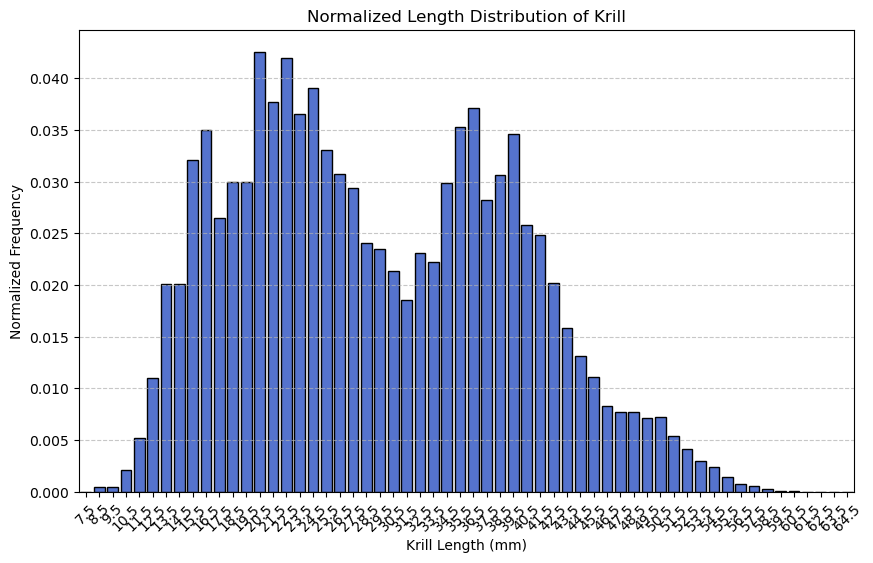

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load krill length data
krill_length = pd.read_csv("krill_length_data_datazoo.csv")

# Extract frequency values
frequencies = krill_length.iloc[-1, 8:-1].values
frequencies = pd.to_numeric(frequencies)  # Convert to numeric

# Define corresponding lengths
lengths = np.arange(7.5, 65, 1)

# Normalize frequencies
normalized_frequencies = frequencies / frequencies.sum()

# Create cleaned DataFrame
krill_length_clean = pd.DataFrame({
    'length': lengths,
    'normalized_frequency': normalized_frequencies
})

# Plot normalized frequency distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=krill_length_clean, x='length', y='normalized_frequency', color='royalblue', edgecolor='black')
plt.xlabel('Krill Length (mm)')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Length Distribution of Krill')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()





In [44]:
import pandas as pd
import numpy as np

# Load the data
krillbase = pd.read_csv("krillbase/krillbase_data.csv", encoding="ISO-8859-1")

# Replace non-numeric entries in 'STANDARDISED_KRILL_UNDER_1M2' column with NaN
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = pd.to_numeric(krillbase['STANDARDISED_KRILL_UNDER_1M2'], errors='coerce')

# Drop rows where 'STANDARDISED_KRILL_UNDER_1M2' is NaN
krillbase = krillbase.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2'])

# Round the values to 2 decimal places to reduce uniqueness
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = krillbase['STANDARDISED_KRILL_UNDER_1M2'].round(2)

# Create latitude and longitude bins
latitude_bins = np.arange(-90, 90 + 4, 4)
longitude_bins = np.arange(-180, 180 + 8, 8)

# Create the binning and label each row
krillbase['lat_bins'] = pd.cut(krillbase['LATITUDE'], bins=latitude_bins)
krillbase['long_bins'] = pd.cut(krillbase['LONGITUDE'], bins=longitude_bins)

# Function to calculate the area of a bin (in square km)
def calculate_area(lat_bin, long_bin):
    # Get the bin edges
    lat_min = lat_bin.left
    lat_max = lat_bin.right
    long_min = long_bin.left
    long_max = long_bin.right
    
    # Approximate length of one degree of latitude in km (approximately 111 km)
    lat_length = 111  # km
    
    # Calculate the average latitude to account for the varying size of longitude
    avg_lat = (lat_min + lat_max) / 2
    # Length of one degree of longitude in km at the average latitude
    long_length = 111.32 * np.cos(np.radians(avg_lat))  # km
    
    # Area of the bin: width (longitude) * height (latitude)
    area = lat_length * (lat_max - lat_min) * long_length * (long_max - long_min)
    return area

# Apply the calculate_area function to each row
krillbase['Area_km2'] = krillbase.apply(lambda row: calculate_area(row['lat_bins'], row['long_bins']), axis=1)



#add a column with the average standardised krill under 1m2 in each bin
krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')

# Check the first few rows to verify

krillbase['no_krill'] = krillbase['Area_km2'] * krillbase['mean_standardised']


# Now, create a new DataFrame that only contains the bins and total number of krill for each bin
krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['no_krill'].sum().reset_index()

# Display the summary DataFrame

#drop the rows with zero krill 
krill_summary = krill_summary[krill_summary['no_krill'] != 0]

#reset index
krill_summary.reset_index(drop=True, inplace=True)

krill_summary

C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1572502837.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')
C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1572502837.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['no_krill'].sum().reset_index()


,lat_bins,long_bins,no_krill
0,"(-78, -74]","(-52, -44]",8.609221e+04
1,"(-78, -74]","(-44, -36]",4.075031e+05
2,"(-78, -74]","(-28, -20]",1.903594e+05
3,"(-74, -70]","(-172, -164]",6.475963e+04
4,"(-74, -70]","(-148, -140]",3.372389e+05
...,...,...,...
128,"(-54, -50]","(-28, -20]",3.659845e+07
129,"(-54, -50]","(-4, 4]",3.410321e+07
130,"(-54, -50]","(4, 12]",2.434379e+05
131,"(-54, -50]","(12, 20]",6.085947e+04
